In [1]:
import pandas as pd
import numpy as np
from gammapy.data import DataStore
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import astropy.units as u
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.irf import Background2D, Background3D
from gammapy.makers import MapDatasetMaker
from gammapy.maps import MapAxis,WcsNDMap, WcsGeom

from copy import deepcopy
import logging
import glob

from regions import CircleSkyRegion, CircleAnnulusSkyRegion


# Make index file for datastore, if necessary

In [3]:
from pyV2DL3.generateObsHduIndex import create_obs_hdu_index_file,get_hdu_type_and_class,gen_obs_index
from os.path import isfile, join
from os import listdir

folder_location = '/raid/biggams/veritas/processed_data_v491/dl3_fullenclosure_moderate2tel/'
index_file_dir = folder_location
hdu_index_file='hdu-index.fits.gz'
obs_index_file='obs-index.fits.gz'
dqm_header=True

__fits_files = glob.glob(f"{folder_location}/[0-9]*.fits*")
if len(__fits_files) == 0:
    logging.info("No FITS files found, trying Eventdisplay-style DL3 archive folder.")
    __fits_files = glob.glob(f"{folder_location}/[0-9]*/[0-9]*.fits*")
fits_files = [
    f
    for f in __fits_files
    if f.find(obs_index_file) == -1 and f.find(hdu_index_file) == -1
]
if not fits_files:
    logging.error("No fits files found")

fits_files.sort()

logging.debug("Found the following fits files:")
for _file in fits_files:
    logging.debug(" -> %s", _file)

logging.info("Found %d fits files", len(fits_files))
create_obs_hdu_index_file(
    fits_files, index_file_dir, hdu_index_file, obs_index_file, dqm_header
)


KeyboardInterrupt



# Select runs

In [ ]:
grb_table = pd.read_csv('grb.txt')

In [ ]:
#datastore = DataStore.from_dir("/raid/jacko/obriens/VERITAS/DL3/v4/dl3_fullenclosure_moderate2tel")
datastore = DataStore.from_dir('/raid/biggams/veritas/processed_data_v491/dl3_fullenclosure_moderate2tel/')

In [ ]:
obs_table = datastore.obs_table

In [ ]:
#obs_table

In [ ]:
obs_table = obs_table.to_pandas()

In [ ]:
grouped = obs_table.groupby(['OBJECT'])['LIVETIME'].agg('sum')/60
grouped = grouped.sort_values()

In [ ]:
pd.set_option('display.max_rows', 500)

np.set_printoptions(threshold=2000)
#grouped.tail(50)

In [ ]:
# filter out extended and strong sources and get write out runlist
drop_list= [b'Crab', b'Mrk421', b'Mrk501',b'MGRO J1908+06 centro',b'Boomerang',b'Sgr A*',b'Sgr A* Off',b'IC443 Hot Spot',b'Gamma Cygni',b'M31',b'LS I +61 303',b'VER J0521+211']
#drop_list=[]
filtered = grouped.drop(drop_list)
#table_gtf = table_gtf.drop(VPM_runs)

filtered[-10:]

In [12]:
runlist = obs_table[obs_table['OBJECT'].isin(filtered.index)]
runlist['LIVETIME'].sum() / 60

801801.0666666667

In [13]:
runlist = runlist[~runlist['OBS_ID'].isin(grb_table[' Run'])]

# Set up directories

In [15]:
def load_exclusion_regions(exclusion_file='VTSCat.csv'):
    """
        Calculate a radial acceptance map

        Parameters
        ----------
        exclusion_file : Path to csv file with coordinates of sources in RA/DEC

        Returns
        -------
        exclusion_regions_vts : list of regions.shapes.circle.CircleSkyRegion
            A list of exclusion regions
    """

    # load VTSCat "catalog"
    VTSCat = pd.read_csv(exclusion_file)
    VTSCat.rename(columns={'pos_ra': 'RA', 'pos_dec': 'DEC', 'common_name': 'Source_Name'}, inplace=True)
    VTSCat[['RA', 'DEC']]
    VTSCat = VTSCat.loc[VTSCat['source_id'] < 100000]  ### only detected sources
    VTSCat['position'] = SkyCoord(VTSCat['RA'], VTSCat['DEC'], unit="deg", frame="icrs")
    ## VTS Cat generated exclusion regions with 0.3° radius, currently 84 known sources
    exclusion_radius = Angle("0.3 deg")
    exclusion_regions_vts = [(VTSCat['RA'][i],VTSCat['DEC'][i], exclusion_radius.value) for i in range(len(VTSCat))]
    return exclusion_regions_vts

In [16]:
exclusion_regions = load_exclusion_regions('./VTSCat.csv')
#exclusion_regions

In [17]:
class BackgroundModelEstimator:
    
    def __init__(self,
        energy, 
        offset,
        excluded_sources,
        smooth,
        smooth_sigma: float = 1,):

        self.excluded_sources = excluded_sources
        self.smooth = smooth
        self.smooth_sigma = smooth_sigma
        self.counts = self._make_bkg2d(energy, offset, unit="")
        self.exposure = self._make_bkg2d(energy, offset, unit="s TeV sr")
        #self.exclusion = ExclusionFinder()
    @staticmethod
    def _make_bkg2d(energy, offset, unit):
        return Background2D(axes=[energy, offset], unit=unit)

    def run(self, observations):
        for obs in observations:
            counts, exposure = self.fill_counts(obs)
            self.counts.data += counts
            self.exposure.quantity += exposure
        #print(self.exposure.quantity)

    def fill_counts(self, obs):
        energy, offset = self.counts.axes
        run_ra = obs.pointing.fixed_icrs.ra.deg
        run_dec = obs.pointing.fixed_icrs.dec.deg
        events = obs.events
        events.table['offset'] = events.offset.to("deg")
        #display(events.table)

        events = MapDatasetEventSampler.event_det_coords(obs, events)
        run_mask = np.ones(len(events.table), dtype=bool)
        for reg in self.excluded_sources:
            run_mask &= ((events.table["RA"] - reg[0]) ** 2 + (events.table["DEC"] - reg[1]) ** 2) > reg[2] ** 2
        counts = np.histogram2d(
            events.energy[~run_mask].to('TeV'), events.offset.to("deg")[~run_mask],
            (energy.edges, offset.edges))[0]  
        self.counts.data += counts
        counts_all = np.histogram(events.offset.to("deg"), bins=offset.edges)[0] + 1e-9
        # Only kept events
        counts_exc = (
            np.histogram(events.offset[~run_mask].to("deg"), bins=offset.edges)[0] + 1e-9
        )

        axes = self.exposure.axes
        offset = axes["offset"].center
        time = obs.observation_time_duration
        exposure = 2 * np.pi * offset * time * axes.bin_volume()
        #print(f'exp time: {time}, offset-corrected: {exposure[0][0]}, all counts: {counts_all[0]}, kept counts {counts_exc[0]},total exposure: {(exposure * (counts_exc / counts_all))[0][0]}')

        # Scale exposure by fraction of events accepted
        # self.exposure.quantity += exposure * (counts_exc / counts_all)
        return counts, exposure * (counts_exc / counts_all)

    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.quantity /= self.exposure.quantity
        if self.smooth:
            rate = poly_smooth(rate)
        return rate
    @property
    def background_rate_error(self):
        rate = deepcopy(self.counts)
        rate.quantity = np.sqrt(rate.quantity)/ self.exposure.quantity
        
        return rate

def smooth(bkg: Background2D, sigma: float = 1.0) -> Background2D:
    bkg_3d = bkg.to_3d()
    for i in range(len(bkg_3d.data)):
        smoothed = gaussian_filter(bkg_3d.data[i, :, :], sigma, 0)
        bkg_3d.data[i, :, :] = smoothed
    return bkg_3d.to_2d

def poly_smooth(bkg):
    offset = bkg.axes['offset'].center.value
    for i in range(len(bkg.data)):
        poly = np.polyfit(offset,bkg.data[i,:],deg=5)
        p = np.poly1d(poly)
        bkg.data[i,:] = p(offset)
    return bkg

In [18]:
emin = 0.01
emax = 100
ebins = 100

energy = MapAxis.from_energy_bounds(
    emin*u.TeV,
    emax*u.TeV,
    ebins,
    name="energy",
    unit="TeV",
)

offset = MapAxis.from_bounds(
    0*u.deg,
    2.5*u.deg,
    nbin=25,
    interp="lin",
    unit="deg",
    name="offset",
)

In [19]:
estimator = BackgroundModelEstimator(
                energy,
                offset,
                smooth=True,
                smooth_sigma=1,
                excluded_sources=exclusion_regions
            )

In [20]:
# get bin-by-bin observations

zeniths = [(0,10),(10,20),(20,30),(30,40),(40,45),(45,50),(50,55),(55,60)]
azimuths = [(-90,90),(90,270)]

epochs = {
        "V4": {"tstart": Time("2000-01-01"), "tstop": Time("2009-09-13")},
        "V5": {"tstart": Time("2009-09-14"), "tstop": Time("2012-07-31")},
        "V6_2012_2013a": {"tstart": Time("2012-08-01"), "tstop": Time("2013-03-15")},
        "V6_2012_2013b": {"tstart": Time("2013-03-16"), "tstop": Time("2013-11-16")},
        "V6_2013_2014a": {"tstart": Time("2013-11-17"), "tstop": Time("2014-05-12")},
        "V6_2013_2014b": {"tstart": Time("2014-05-13"), "tstop": Time("2014-11-07")},
        "V6_2014_2015": {"tstart": Time("2014-11-08"), "tstop": Time("2015-07-31")},
        "V6_2015_2016": {"tstart": Time("2015-08-01"), "tstop": Time("2016-07-31")},
        "V6_2016_2017": {"tstart": Time("2016-08-01"), "tstop": Time("2017-07-31")},
        "V6_2017_2018": {"tstart": Time("2017-08-01"), "tstop": Time("2018-07-31")},
        "V6_2018_2019": {"tstart": Time("2018-08-01"), "tstop": Time("2019-11-12")},
        "V6_2019_2020w": {"tstart": Time("2019-11-13"), "tstop": Time("2020-05-07")},
        "V6_2020_2020s": {"tstart": Time("2020-05-08"), "tstop": Time("2020-11-04")},
        "V6_2020_2021w": {"tstart": Time("2020-11-05"), "tstop": Time("2021-04-27")},
        "V6_2021_2021s": {"tstart": Time("2021-04-28"), "tstop": Time("2021-11-16")},
        "V6_2021_2022w": {"tstart": Time("2021-11-17"), "tstop": Time("2022-05-09")},
        #  "V6_2022_2022s" : {"tstart"  :Time("2022-05-10"), "tstop" : Time("2022-11-08")},
        "V6_2022_2022s": {"tstart": Time("2022-05-10"), "tstop": Time("2025-11-08")},
    }

#estimator.run(observations)

  0%|                                                                                                      | 0/17 [00:00<?, ?it/s]

V4 (0, 10) (-90, 90)
V4 (10, 20) (-90, 90)
V4 (20, 30) (-90, 90)
V4 (30, 40) (-90, 90)
V4 (40, 45) (-90, 90)
V4 (45, 50) (-90, 90)
V4 (50, 55) (-90, 90)
V4 (55, 60) (-90, 90)
V4 (0, 10) (90, 270)
V4 (10, 20) (90, 270)
V4 (20, 30) (90, 270)
V4 (30, 40) (90, 270)
V4 (40, 45) (90, 270)
V4 (45, 50) (90, 270)
V4 (50, 55) (90, 270)
V4 (55, 60) (90, 270)
V5 (0, 10) (-90, 90)
V5 (10, 20) (-90, 90)
V5 (20, 30) (-90, 90)
V5 (30, 40) (-90, 90)
V5 (40, 45) (-90, 90)
V5 (45, 50) (-90, 90)
V5 (50, 55) (-90, 90)
V5 (55, 60) (-90, 90)
V5 (0, 10) (90, 270)
V5 (10, 20) (90, 270)
V5 (20, 30) (90, 270)
V5 (30, 40) (90, 270)
V5 (40, 45) (90, 270)
V5 (45, 50) (90, 270)
V5 (50, 55) (90, 270)
V5 (55, 60) (90, 270)
V6_2012_2013a (0, 10) (-90, 90)
V6_2012_2013a (10, 20) (-90, 90)
V6_2012_2013a (20, 30) (-90, 90)
V6_2012_2013a (30, 40) (-90, 90)
V6_2012_2013a (40, 45) (-90, 90)
V6_2012_2013a (45, 50) (-90, 90)
V6_2012_2013a (50, 55) (-90, 90)
V6_2012_2013a (55, 60) (-90, 90)
V6_2012_2013a (0, 10) (90, 270)
V6_20

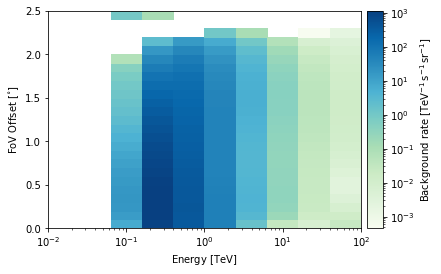

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2013_2014a.fits
V6_2013_2014a (30, 40) (-90, 90)


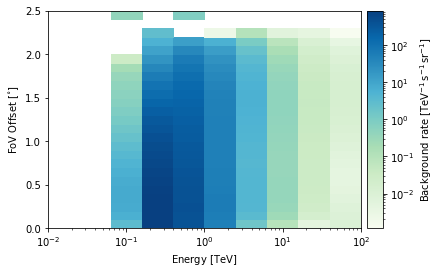

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2013_2014a.fits
V6_2013_2014a (40, 45) (-90, 90)


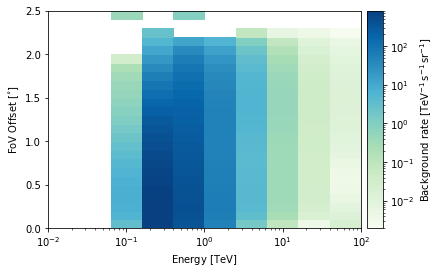

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2013_2014a.fits
V6_2013_2014a (45, 50) (-90, 90)


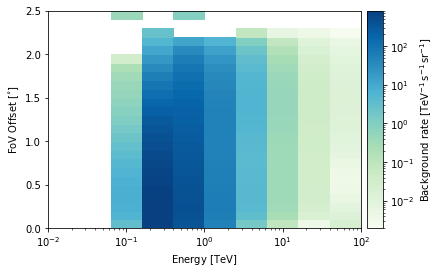

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2013_2014a.fits
V6_2013_2014a (50, 55) (-90, 90)


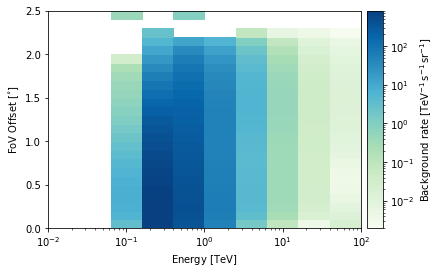

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2013_2014a.fits
V6_2013_2014a (55, 60) (-90, 90)


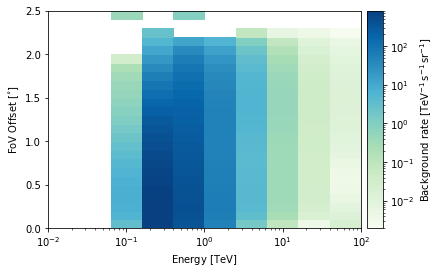

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2013_2014a.fits
V6_2013_2014a (0, 10) (90, 270)


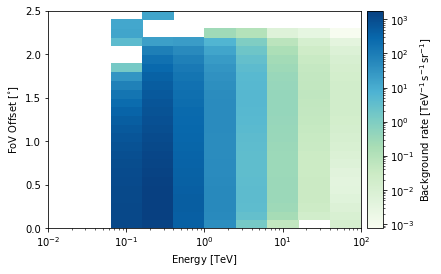

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2013_2014a.fits
V6_2013_2014a (10, 20) (90, 270)


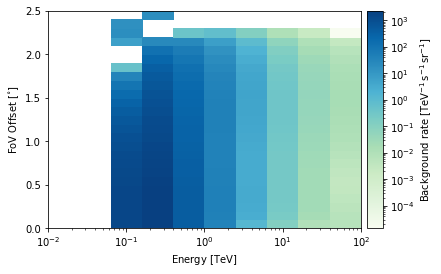

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2013_2014a.fits
V6_2013_2014a (20, 30) (90, 270)


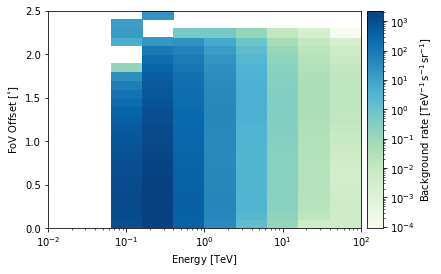

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2013_2014a.fits
V6_2013_2014a (30, 40) (90, 270)


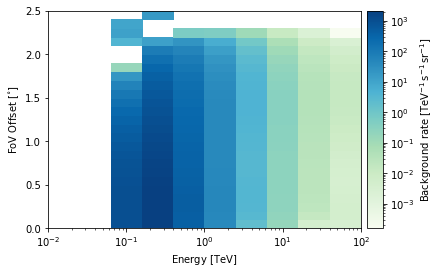

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2013_2014a.fits
V6_2013_2014a (40, 45) (90, 270)


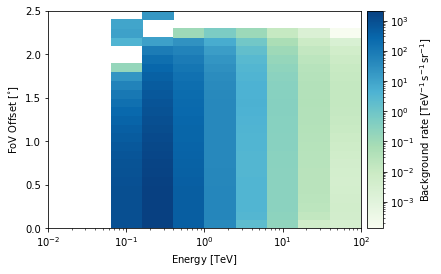

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2013_2014a.fits
V6_2013_2014a (45, 50) (90, 270)


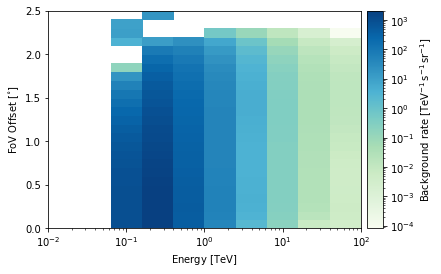

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2013_2014a.fits
V6_2013_2014a (50, 55) (90, 270)


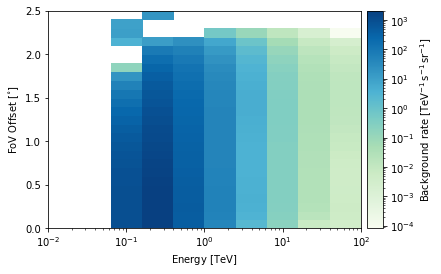

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2013_2014a.fits
V6_2013_2014a (55, 60) (90, 270)


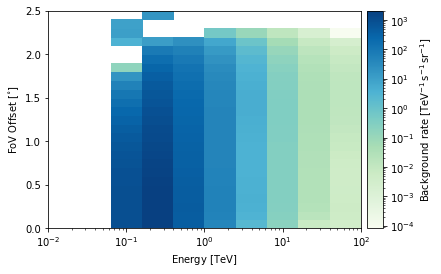

 29%|███████████████████████████▋                                                                  | 5/17 [01:05<02:37, 13.13s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2013_2014a.fits
V6_2013_2014b (0, 10) (-90, 90)


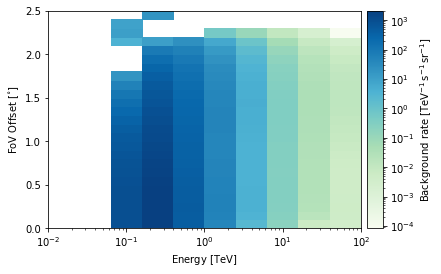

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2013_2014b.fits
V6_2013_2014b (10, 20) (-90, 90)


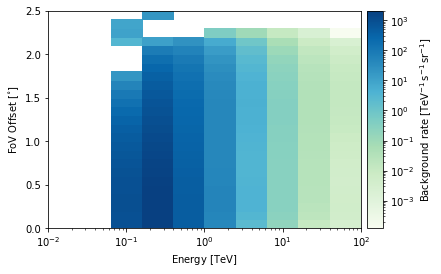

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2013_2014b.fits
V6_2013_2014b (20, 30) (-90, 90)


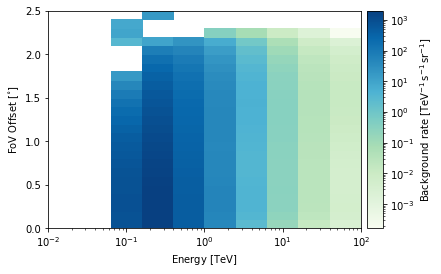

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2013_2014b.fits
V6_2013_2014b (30, 40) (-90, 90)


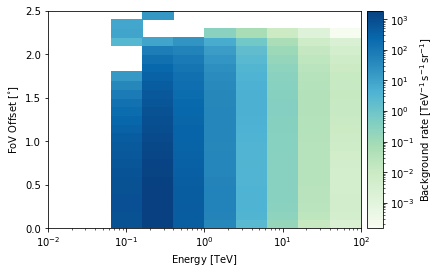

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2013_2014b.fits
V6_2013_2014b (40, 45) (-90, 90)


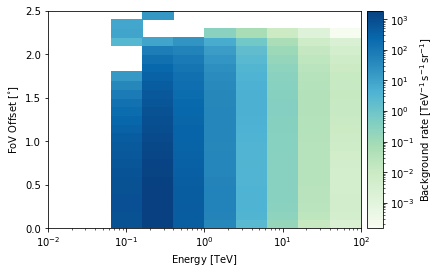

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2013_2014b.fits
V6_2013_2014b (45, 50) (-90, 90)


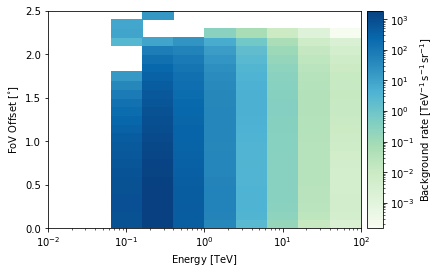

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2013_2014b.fits
V6_2013_2014b (50, 55) (-90, 90)


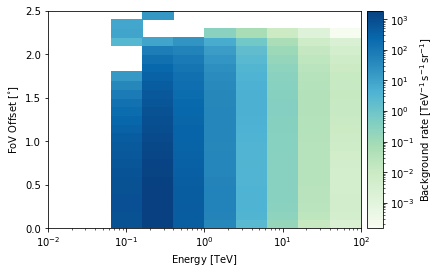

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2013_2014b.fits
V6_2013_2014b (55, 60) (-90, 90)


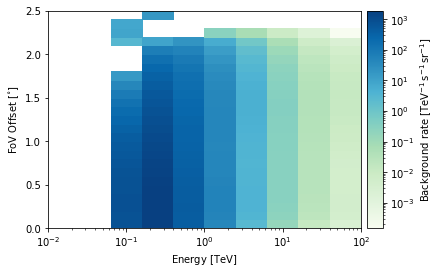

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2013_2014b.fits
V6_2013_2014b (0, 10) (90, 270)


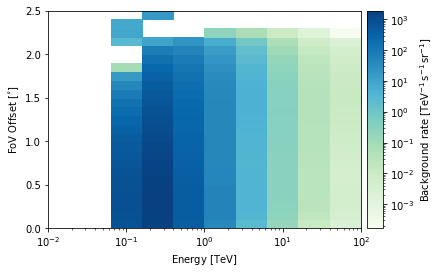

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2013_2014b.fits
V6_2013_2014b (10, 20) (90, 270)


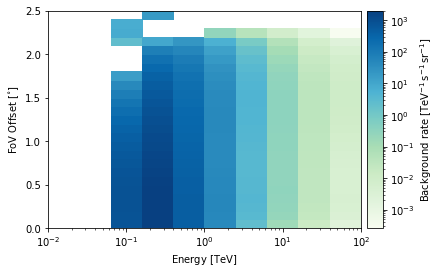

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2013_2014b.fits
V6_2013_2014b (20, 30) (90, 270)


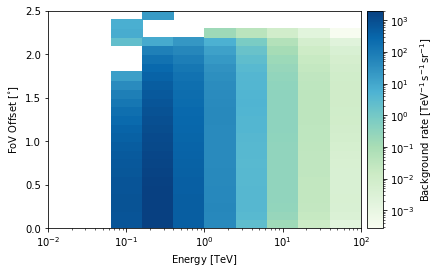

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2013_2014b.fits
V6_2013_2014b (30, 40) (90, 270)


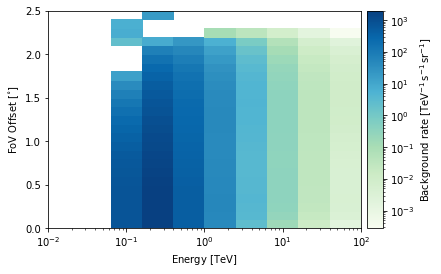

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2013_2014b.fits
V6_2013_2014b (40, 45) (90, 270)


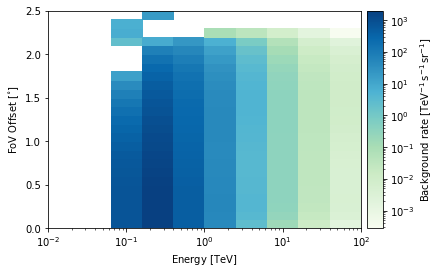

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2013_2014b.fits
V6_2013_2014b (45, 50) (90, 270)


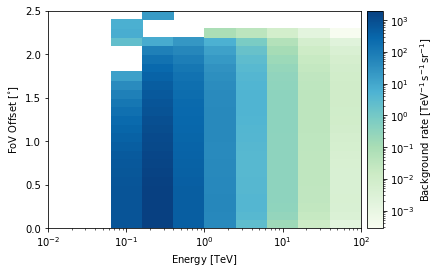

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2013_2014b.fits
V6_2013_2014b (50, 55) (90, 270)


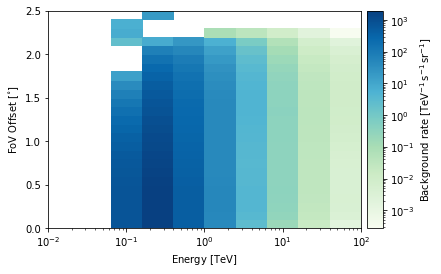

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2013_2014b.fits
V6_2013_2014b (55, 60) (90, 270)


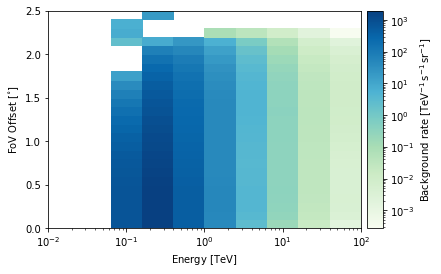

 35%|█████████████████████████████████▏                                                            | 6/17 [01:54<03:52, 21.10s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2013_2014b.fits
V6_2014_2015 (0, 10) (-90, 90)


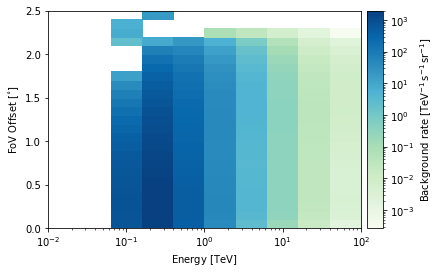

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2014_2015.fits
V6_2014_2015 (10, 20) (-90, 90)


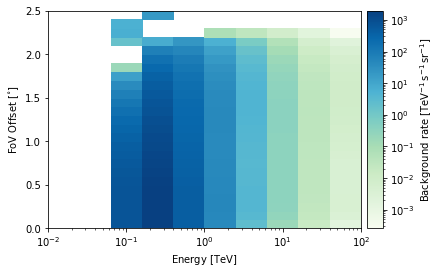

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2014_2015.fits
V6_2014_2015 (20, 30) (-90, 90)


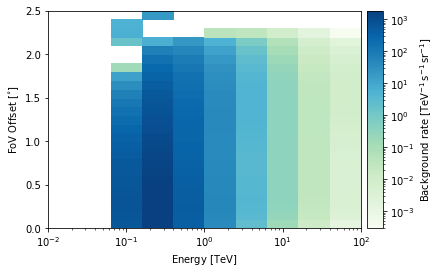

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2014_2015.fits
V6_2014_2015 (30, 40) (-90, 90)


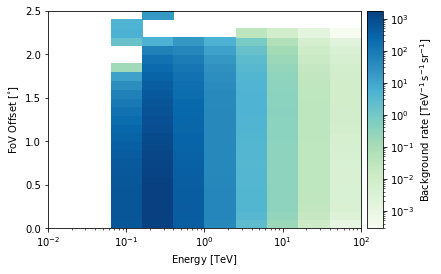

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2014_2015.fits
V6_2014_2015 (40, 45) (-90, 90)


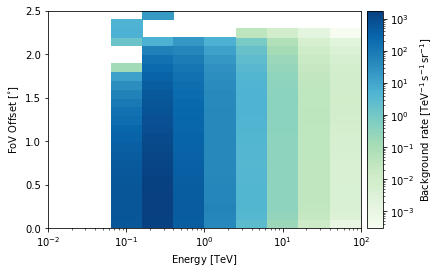

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2014_2015.fits
V6_2014_2015 (45, 50) (-90, 90)


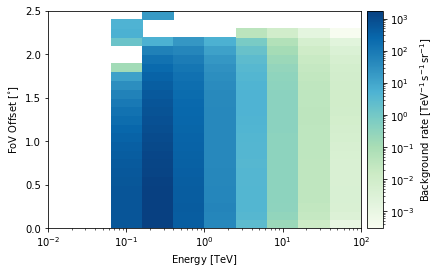

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2014_2015.fits
V6_2014_2015 (50, 55) (-90, 90)


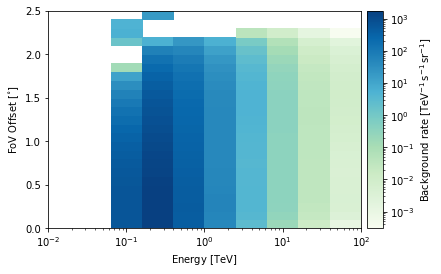

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2014_2015.fits
V6_2014_2015 (55, 60) (-90, 90)


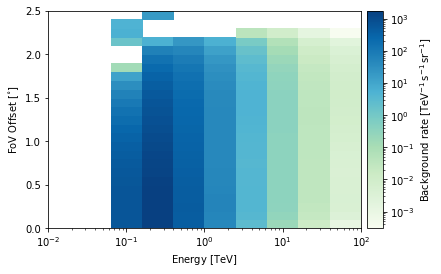

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2014_2015.fits
V6_2014_2015 (0, 10) (90, 270)


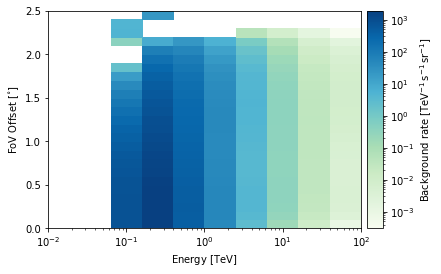

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2014_2015.fits
V6_2014_2015 (10, 20) (90, 270)


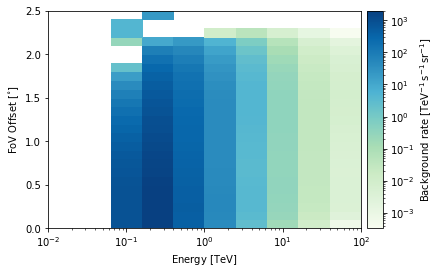

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2014_2015.fits
V6_2014_2015 (20, 30) (90, 270)


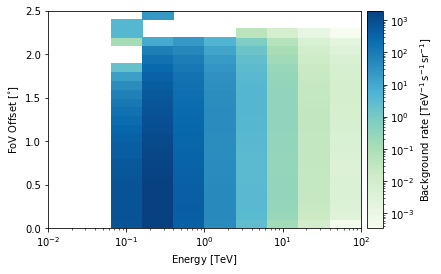

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2014_2015.fits
V6_2014_2015 (30, 40) (90, 270)


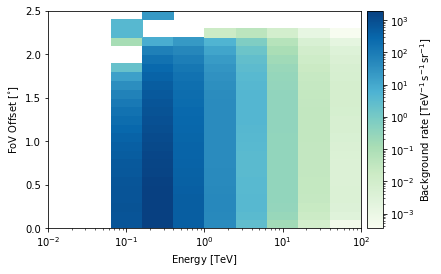

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2014_2015.fits
V6_2014_2015 (40, 45) (90, 270)


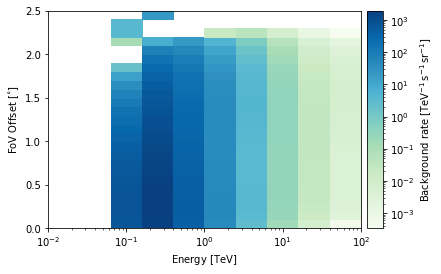

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2014_2015.fits
V6_2014_2015 (45, 50) (90, 270)


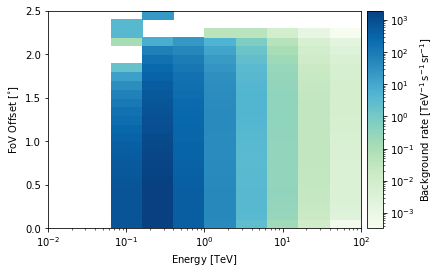

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2014_2015.fits
V6_2014_2015 (50, 55) (90, 270)


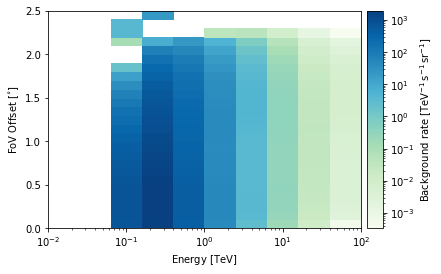

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2014_2015.fits
V6_2014_2015 (55, 60) (90, 270)


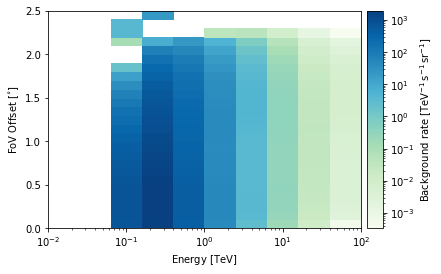

 41%|██████████████████████████████████████▋                                                       | 7/17 [03:29<06:29, 38.97s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2014_2015.fits
V6_2015_2016 (0, 10) (-90, 90)


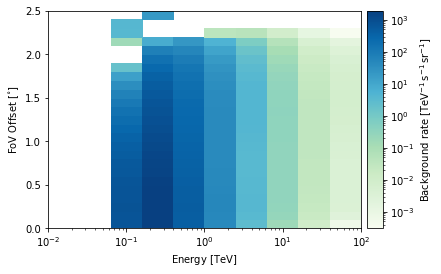

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2015_2016.fits
V6_2015_2016 (10, 20) (-90, 90)


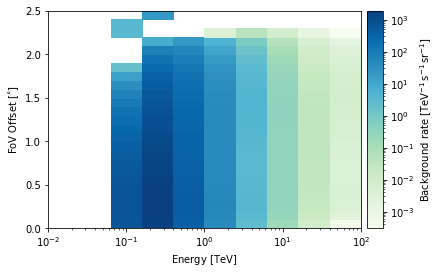

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2015_2016.fits
V6_2015_2016 (20, 30) (-90, 90)


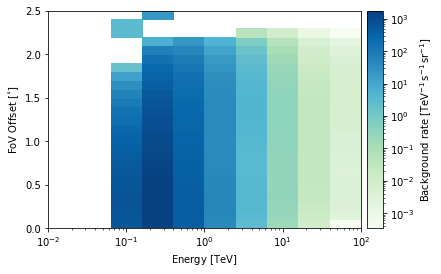

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2015_2016.fits
V6_2015_2016 (30, 40) (-90, 90)


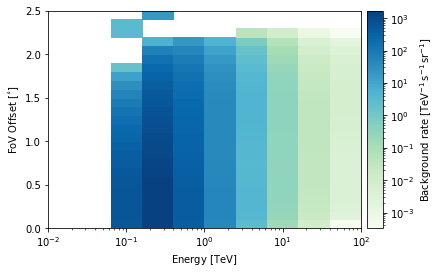

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2015_2016.fits
V6_2015_2016 (40, 45) (-90, 90)


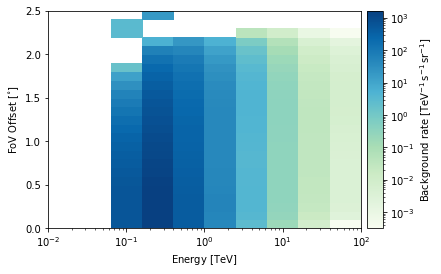

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2015_2016.fits
V6_2015_2016 (45, 50) (-90, 90)


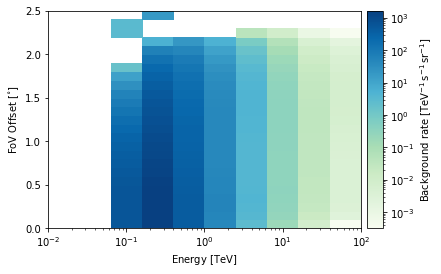

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2015_2016.fits
V6_2015_2016 (50, 55) (-90, 90)


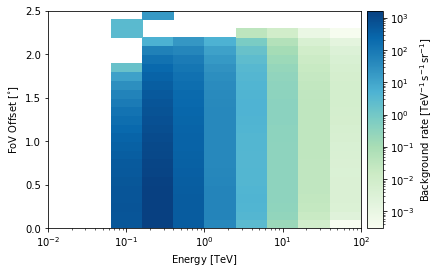

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2015_2016.fits
V6_2015_2016 (55, 60) (-90, 90)


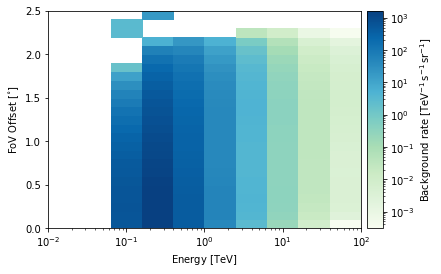

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2015_2016.fits
V6_2015_2016 (0, 10) (90, 270)


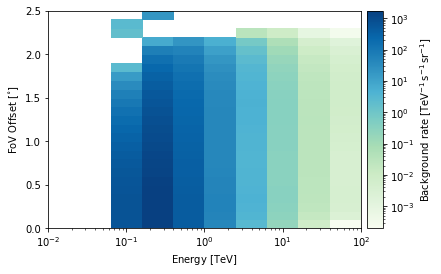

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2015_2016.fits
V6_2015_2016 (10, 20) (90, 270)


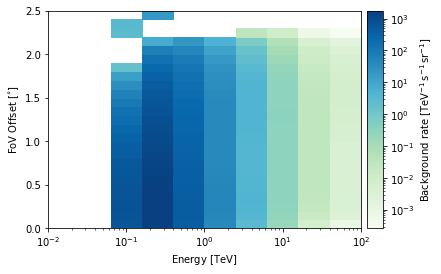

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2015_2016.fits
V6_2015_2016 (20, 30) (90, 270)


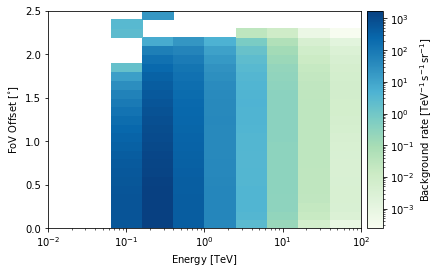

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2015_2016.fits
V6_2015_2016 (30, 40) (90, 270)


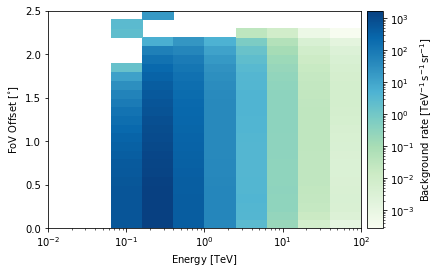

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2015_2016.fits
V6_2015_2016 (40, 45) (90, 270)


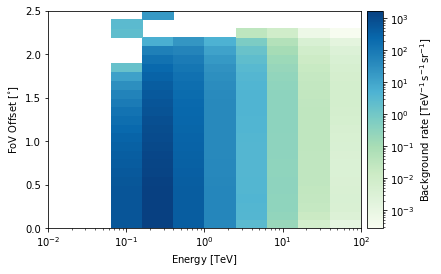

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2015_2016.fits
V6_2015_2016 (45, 50) (90, 270)


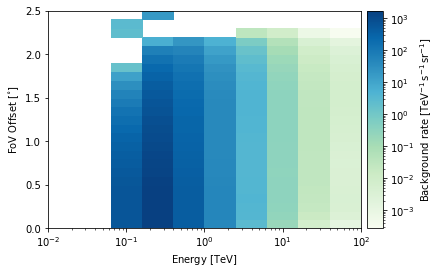

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2015_2016.fits
V6_2015_2016 (50, 55) (90, 270)


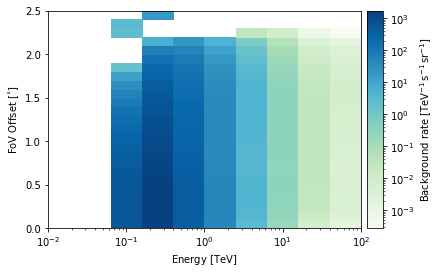

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2015_2016.fits
V6_2015_2016 (55, 60) (90, 270)


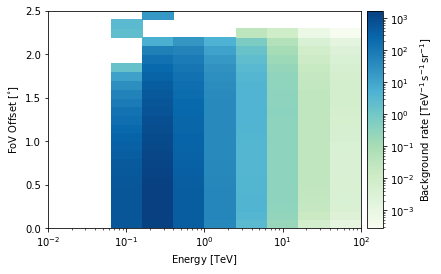

 47%|████████████████████████████████████████████▏                                                 | 8/17 [05:36<09:12, 61.40s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2015_2016.fits
V6_2016_2017 (0, 10) (-90, 90)


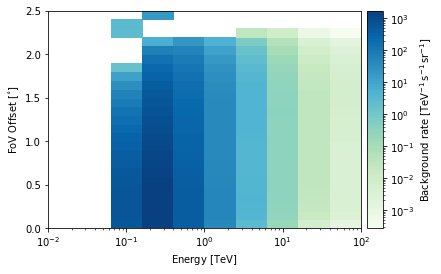

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2016_2017.fits
V6_2016_2017 (10, 20) (-90, 90)


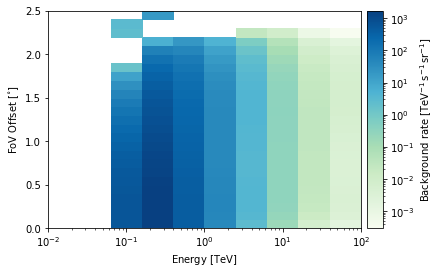

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2016_2017.fits
V6_2016_2017 (20, 30) (-90, 90)


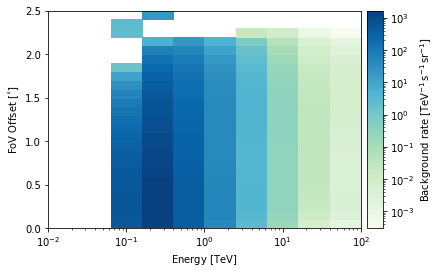

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2016_2017.fits
V6_2016_2017 (30, 40) (-90, 90)


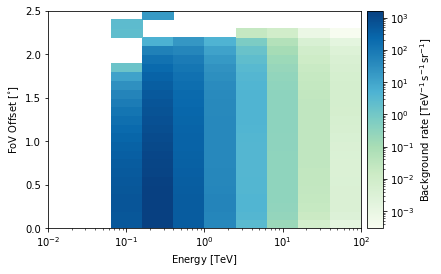

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2016_2017.fits
V6_2016_2017 (40, 45) (-90, 90)


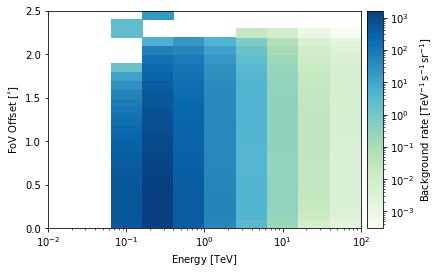

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2016_2017.fits
V6_2016_2017 (45, 50) (-90, 90)


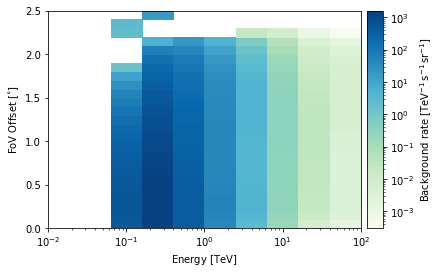

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2016_2017.fits
V6_2016_2017 (50, 55) (-90, 90)


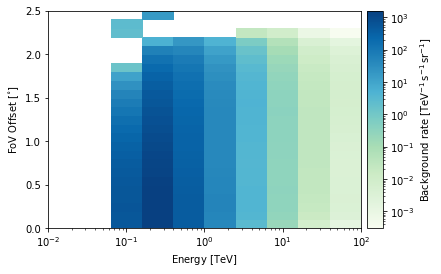

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2016_2017.fits
V6_2016_2017 (55, 60) (-90, 90)


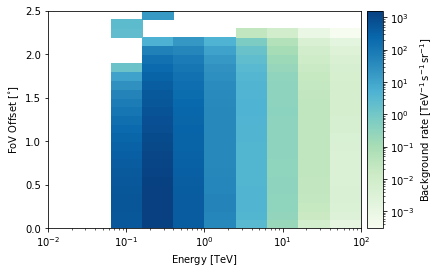

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2016_2017.fits
V6_2016_2017 (0, 10) (90, 270)


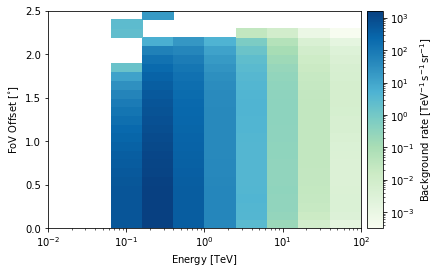

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2016_2017.fits
V6_2016_2017 (10, 20) (90, 270)


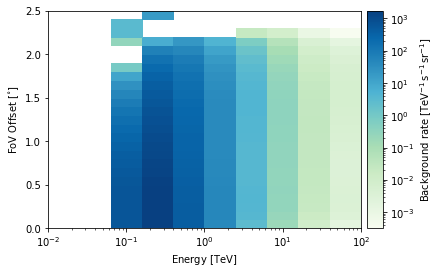

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2016_2017.fits
V6_2016_2017 (20, 30) (90, 270)


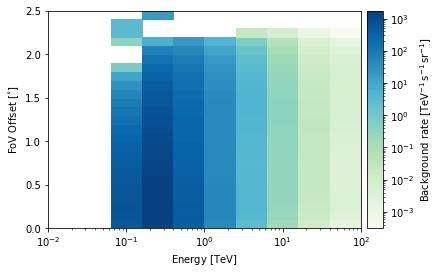

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2016_2017.fits
V6_2016_2017 (30, 40) (90, 270)


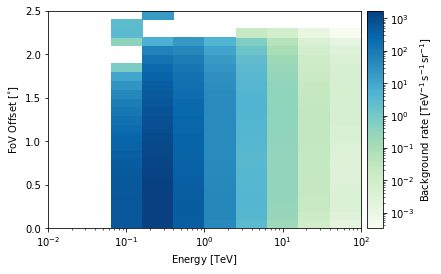

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2016_2017.fits
V6_2016_2017 (40, 45) (90, 270)


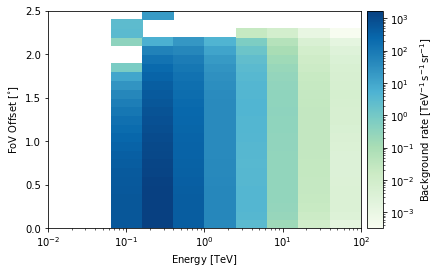

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2016_2017.fits
V6_2016_2017 (45, 50) (90, 270)


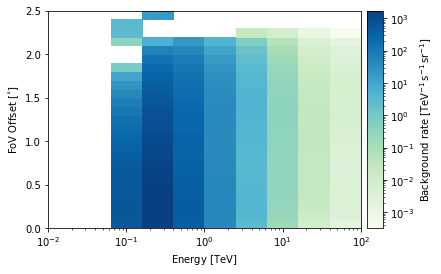

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2016_2017.fits
V6_2016_2017 (50, 55) (90, 270)


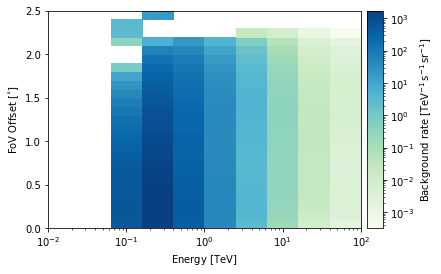

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2016_2017.fits
V6_2016_2017 (55, 60) (90, 270)


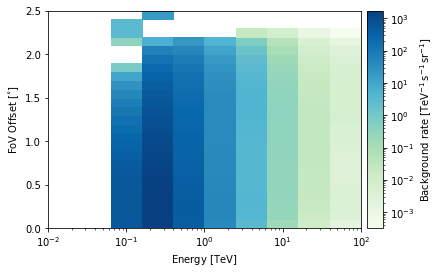

 53%|█████████████████████████████████████████████████▊                                            | 9/17 [07:47<10:40, 80.11s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2016_2017.fits
V6_2017_2018 (0, 10) (-90, 90)


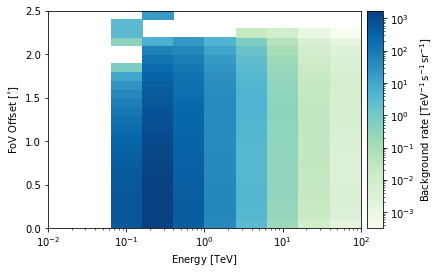

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2017_2018.fits
V6_2017_2018 (10, 20) (-90, 90)


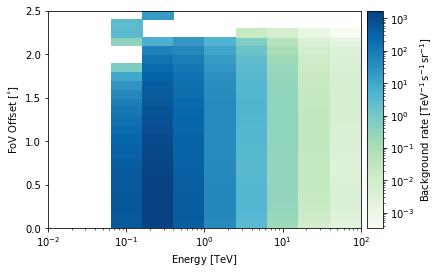

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2017_2018.fits
V6_2017_2018 (20, 30) (-90, 90)


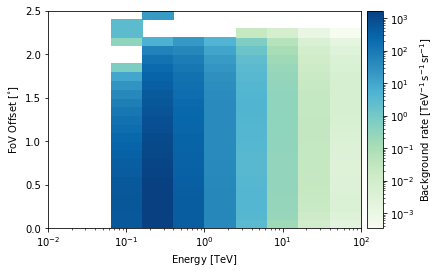

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2017_2018.fits
V6_2017_2018 (30, 40) (-90, 90)


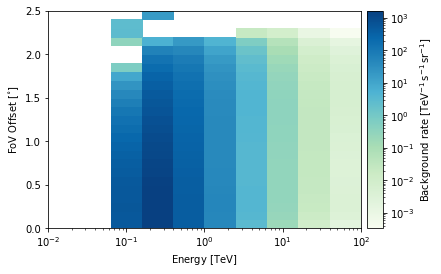

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2017_2018.fits
V6_2017_2018 (40, 45) (-90, 90)


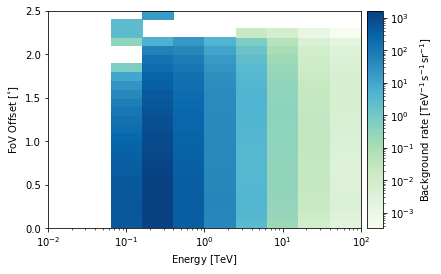

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2017_2018.fits
V6_2017_2018 (45, 50) (-90, 90)


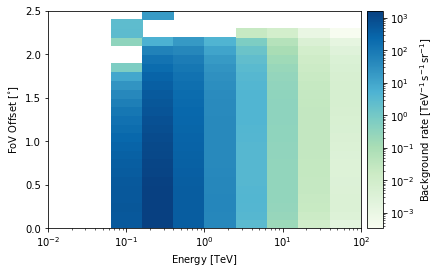

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2017_2018.fits
V6_2017_2018 (50, 55) (-90, 90)


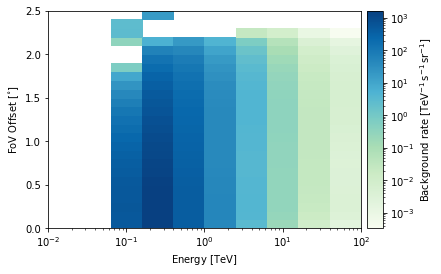

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2017_2018.fits
V6_2017_2018 (55, 60) (-90, 90)


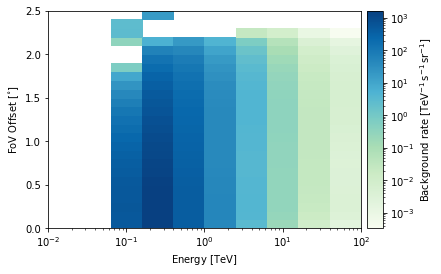

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2017_2018.fits
V6_2017_2018 (0, 10) (90, 270)


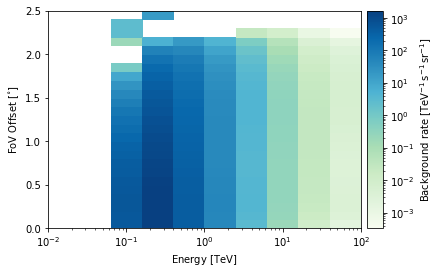

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2017_2018.fits
V6_2017_2018 (10, 20) (90, 270)


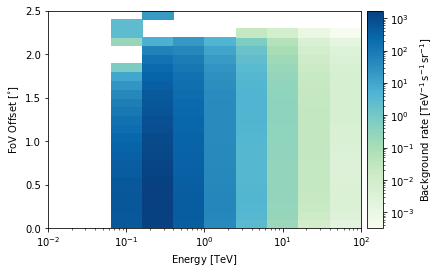

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2017_2018.fits
V6_2017_2018 (20, 30) (90, 270)


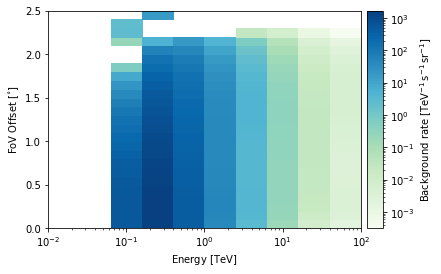

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2017_2018.fits
V6_2017_2018 (30, 40) (90, 270)


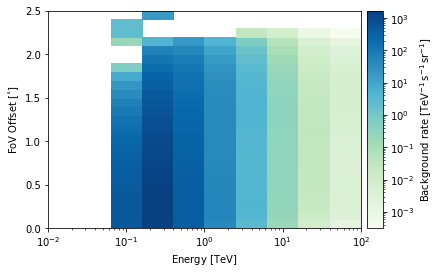

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2017_2018.fits
V6_2017_2018 (40, 45) (90, 270)


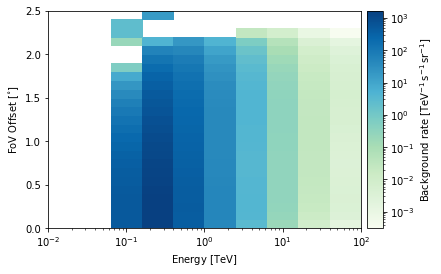

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2017_2018.fits
V6_2017_2018 (45, 50) (90, 270)


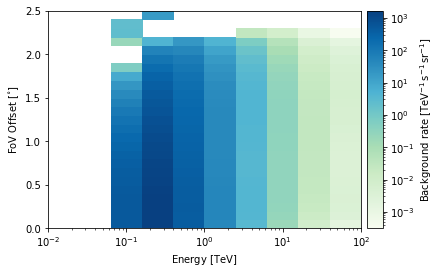

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2017_2018.fits
V6_2017_2018 (50, 55) (90, 270)


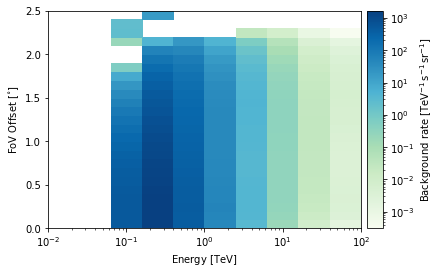

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2017_2018.fits
V6_2017_2018 (55, 60) (90, 270)


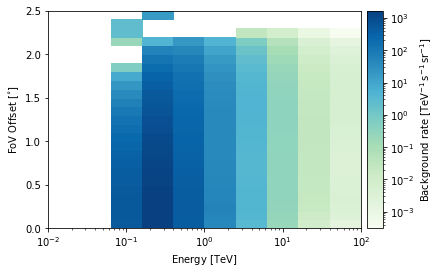

 59%|██████████████████████████████████████████████████████▋                                      | 10/17 [09:55<10:53, 93.36s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2017_2018.fits
V6_2018_2019 (0, 10) (-90, 90)


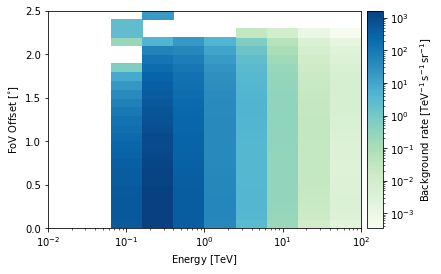

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2018_2019.fits
V6_2018_2019 (10, 20) (-90, 90)


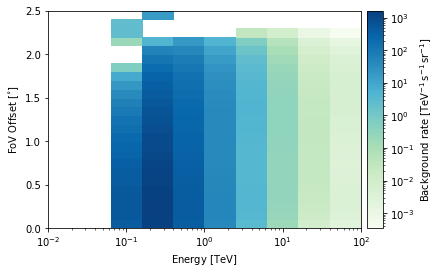

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2018_2019.fits
V6_2018_2019 (20, 30) (-90, 90)


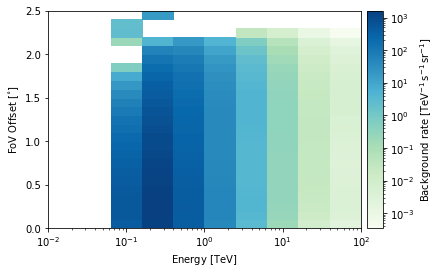

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2018_2019.fits
V6_2018_2019 (30, 40) (-90, 90)


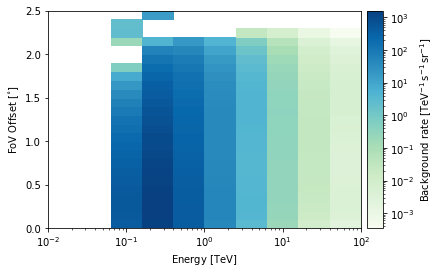

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2018_2019.fits
V6_2018_2019 (40, 45) (-90, 90)


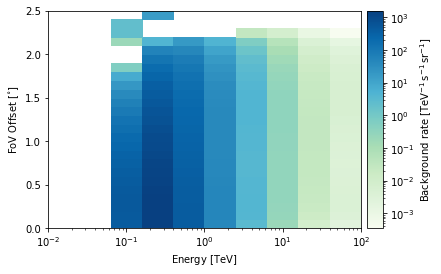

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2018_2019.fits
V6_2018_2019 (45, 50) (-90, 90)


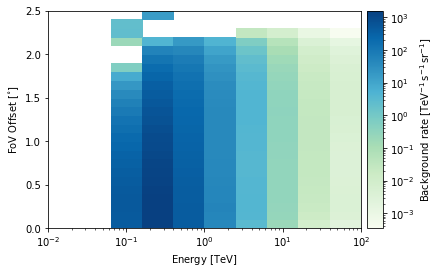

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2018_2019.fits
V6_2018_2019 (50, 55) (-90, 90)


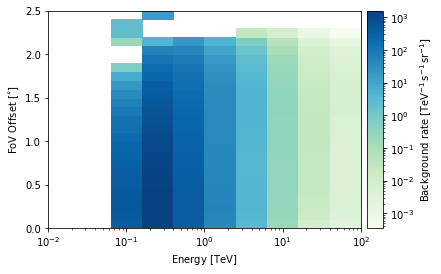

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2018_2019.fits
V6_2018_2019 (55, 60) (-90, 90)


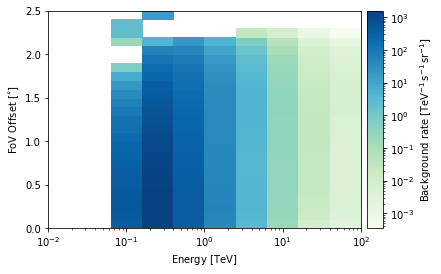

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2018_2019.fits
V6_2018_2019 (0, 10) (90, 270)


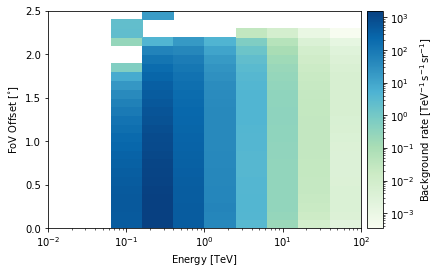

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2018_2019.fits
V6_2018_2019 (10, 20) (90, 270)


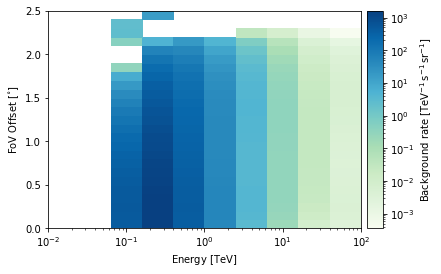

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2018_2019.fits
V6_2018_2019 (20, 30) (90, 270)


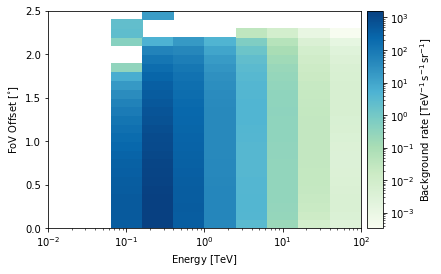

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2018_2019.fits
V6_2018_2019 (30, 40) (90, 270)


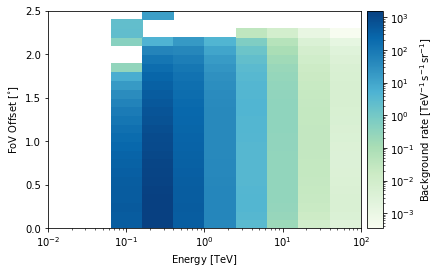

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2018_2019.fits
V6_2018_2019 (40, 45) (90, 270)


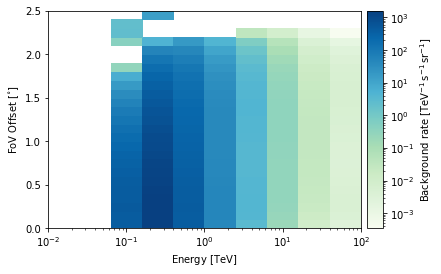

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2018_2019.fits
V6_2018_2019 (45, 50) (90, 270)


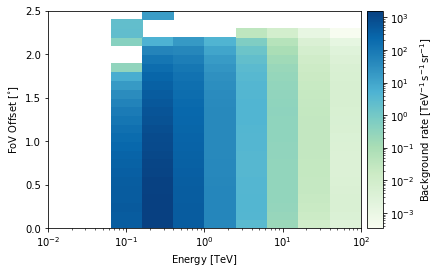

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2018_2019.fits
V6_2018_2019 (50, 55) (90, 270)


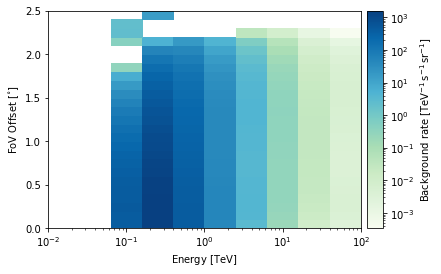

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2018_2019.fits
V6_2018_2019 (55, 60) (90, 270)


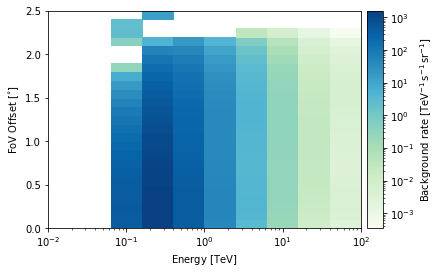

 65%|████████████████████████████████████████████████████████████▏                                | 11/17 [11:43<09:44, 97.48s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2018_2019.fits
V6_2019_2020w (0, 10) (-90, 90)


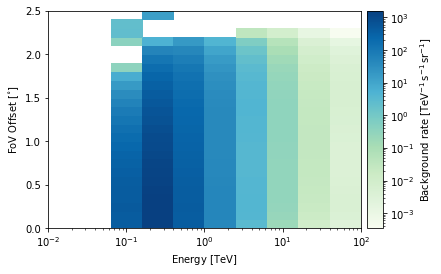

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2019_2020w.fits
V6_2019_2020w (10, 20) (-90, 90)


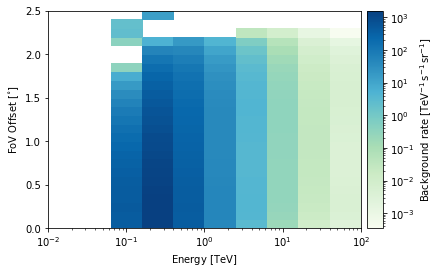

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2019_2020w.fits
V6_2019_2020w (20, 30) (-90, 90)


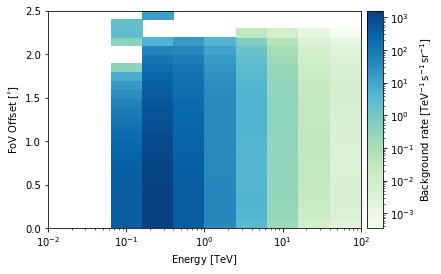

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2019_2020w.fits
V6_2019_2020w (30, 40) (-90, 90)


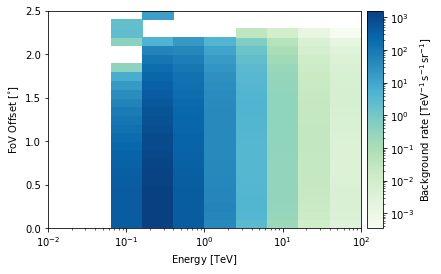

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2019_2020w.fits
V6_2019_2020w (40, 45) (-90, 90)


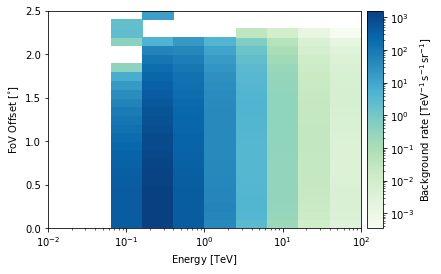

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2019_2020w.fits
V6_2019_2020w (45, 50) (-90, 90)


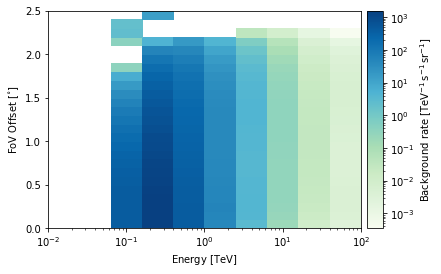

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2019_2020w.fits
V6_2019_2020w (50, 55) (-90, 90)


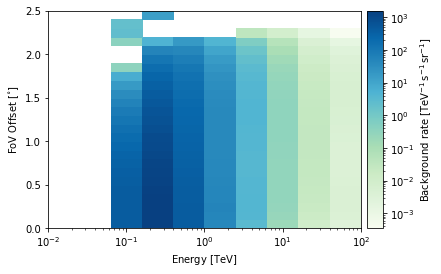

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2019_2020w.fits
V6_2019_2020w (55, 60) (-90, 90)


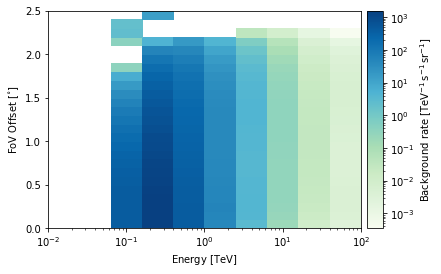

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2019_2020w.fits
V6_2019_2020w (0, 10) (90, 270)


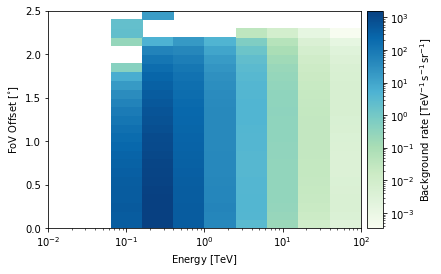

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2019_2020w.fits
V6_2019_2020w (10, 20) (90, 270)


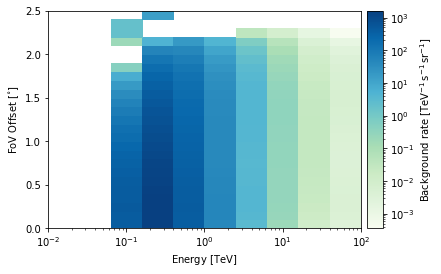

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2019_2020w.fits
V6_2019_2020w (20, 30) (90, 270)


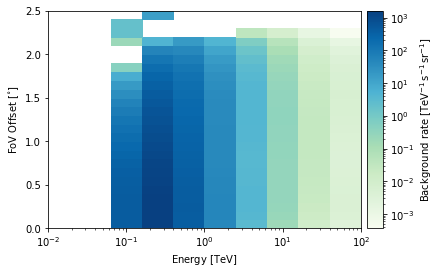

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2019_2020w.fits
V6_2019_2020w (30, 40) (90, 270)


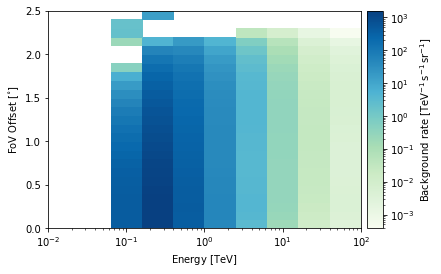

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2019_2020w.fits
V6_2019_2020w (40, 45) (90, 270)


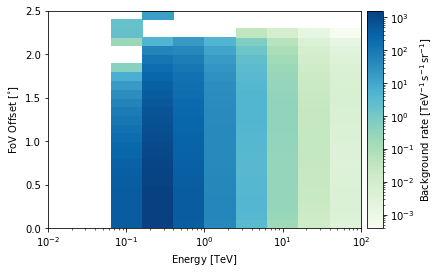

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2019_2020w.fits
V6_2019_2020w (45, 50) (90, 270)


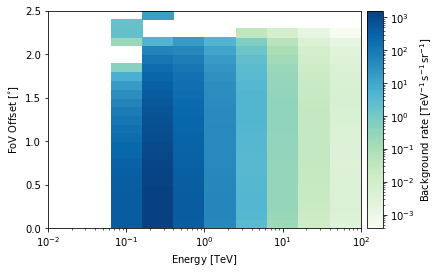

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2019_2020w.fits
V6_2019_2020w (50, 55) (90, 270)


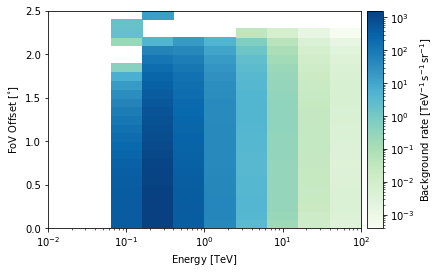

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2019_2020w.fits
V6_2019_2020w (55, 60) (90, 270)


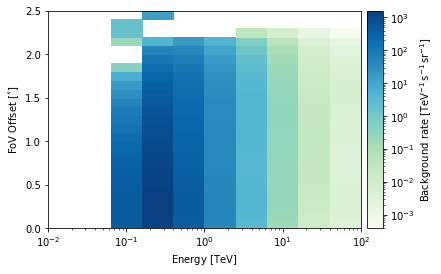

 71%|█████████████████████████████████████████████████████████████████▋                           | 12/17 [12:34<07:00, 84.09s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2019_2020w.fits
V6_2020_2020s (0, 10) (-90, 90)


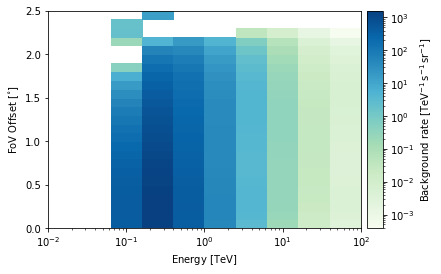

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2020_2020s.fits
V6_2020_2020s (10, 20) (-90, 90)


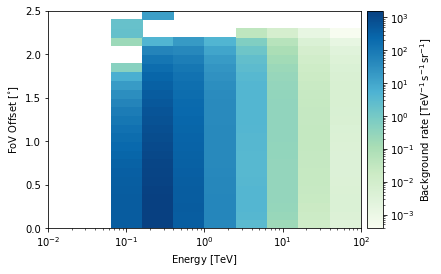

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2020_2020s.fits
V6_2020_2020s (20, 30) (-90, 90)


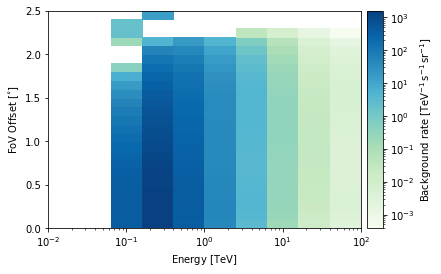

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2020_2020s.fits
V6_2020_2020s (30, 40) (-90, 90)


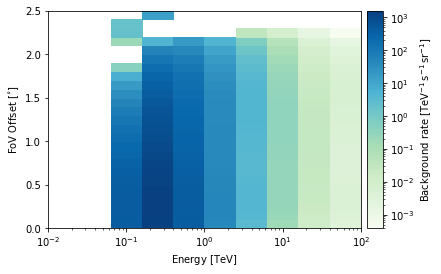

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2020_2020s.fits
V6_2020_2020s (40, 45) (-90, 90)


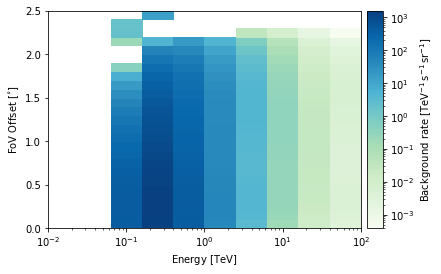

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2020_2020s.fits
V6_2020_2020s (45, 50) (-90, 90)


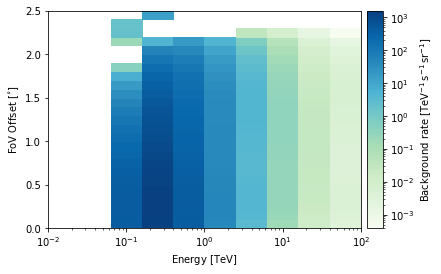

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2020_2020s.fits
V6_2020_2020s (50, 55) (-90, 90)


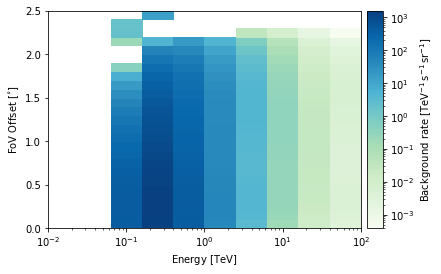

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2020_2020s.fits
V6_2020_2020s (55, 60) (-90, 90)


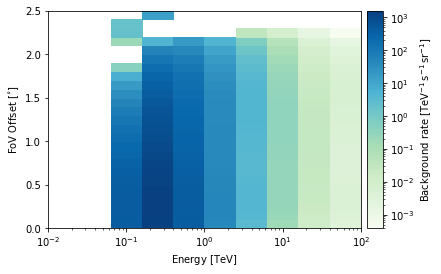

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2020_2020s.fits
V6_2020_2020s (0, 10) (90, 270)


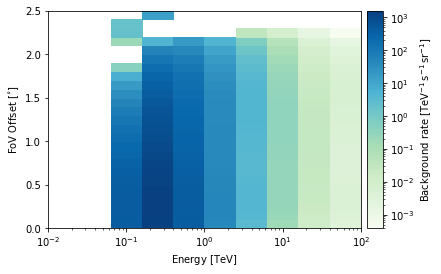

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2020_2020s.fits
V6_2020_2020s (10, 20) (90, 270)


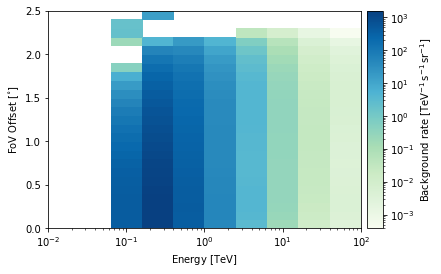

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2020_2020s.fits
V6_2020_2020s (20, 30) (90, 270)


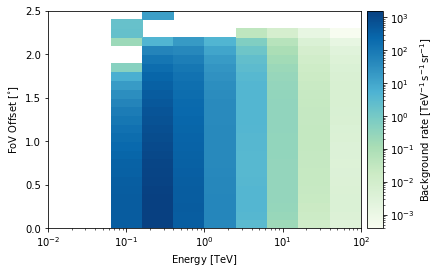

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2020_2020s.fits
V6_2020_2020s (30, 40) (90, 270)


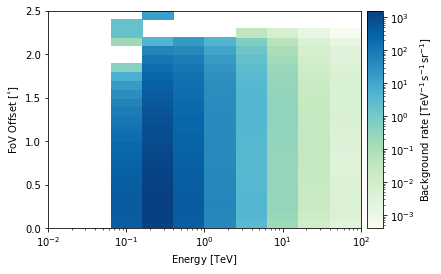

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2020_2020s.fits
V6_2020_2020s (40, 45) (90, 270)


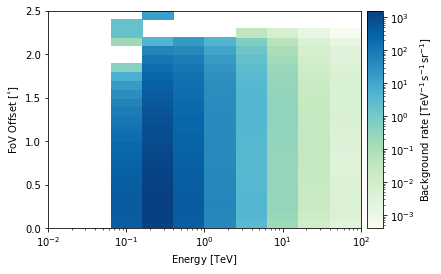

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2020_2020s.fits
V6_2020_2020s (45, 50) (90, 270)


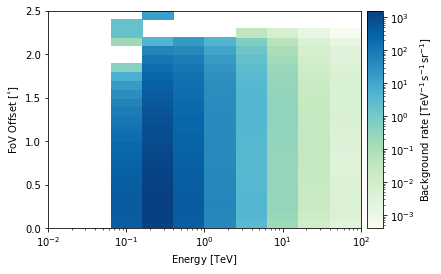

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2020_2020s.fits
V6_2020_2020s (50, 55) (90, 270)


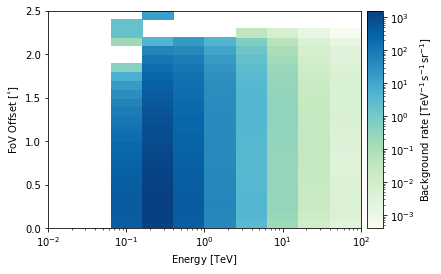

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2020_2020s.fits
V6_2020_2020s (55, 60) (90, 270)


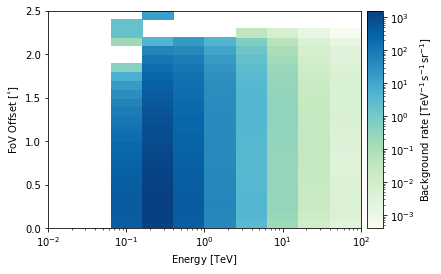

 76%|███████████████████████████████████████████████████████████████████████                      | 13/17 [12:54<04:21, 65.37s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2020_2020s.fits
V6_2020_2021w (0, 10) (-90, 90)


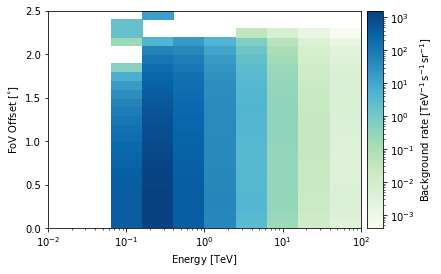

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2020_2021w.fits
V6_2020_2021w (10, 20) (-90, 90)


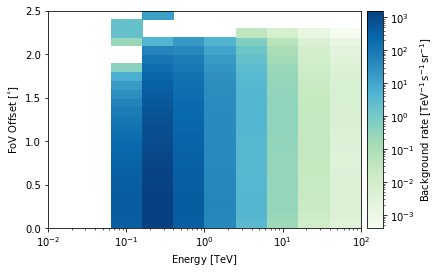

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2020_2021w.fits
V6_2020_2021w (20, 30) (-90, 90)


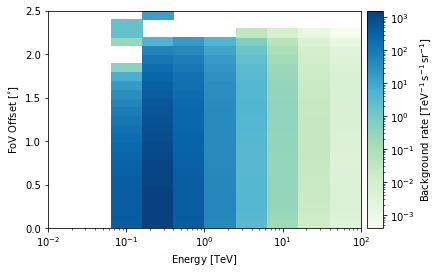

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2020_2021w.fits
V6_2020_2021w (30, 40) (-90, 90)


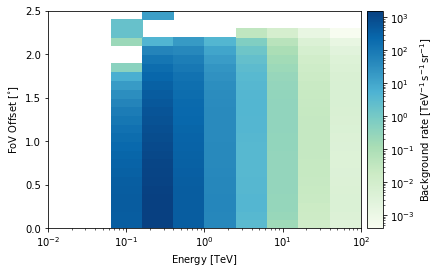

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2020_2021w.fits
V6_2020_2021w (40, 45) (-90, 90)


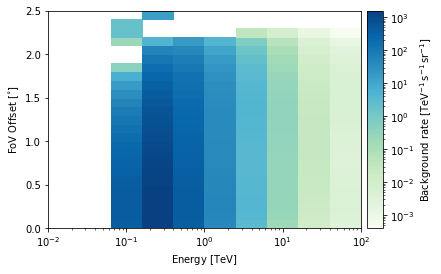

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2020_2021w.fits
V6_2020_2021w (45, 50) (-90, 90)


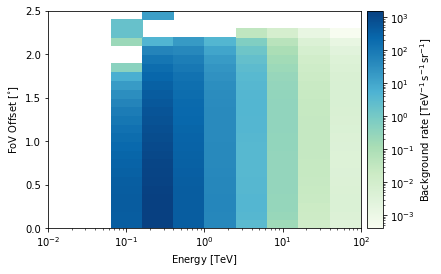

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2020_2021w.fits
V6_2020_2021w (50, 55) (-90, 90)


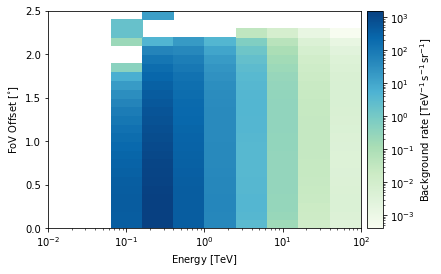

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2020_2021w.fits
V6_2020_2021w (55, 60) (-90, 90)


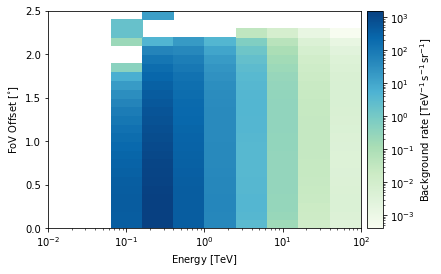

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2020_2021w.fits
V6_2020_2021w (0, 10) (90, 270)


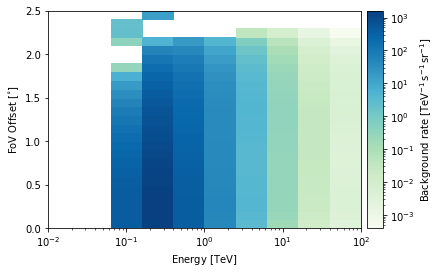

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2020_2021w.fits
V6_2020_2021w (10, 20) (90, 270)


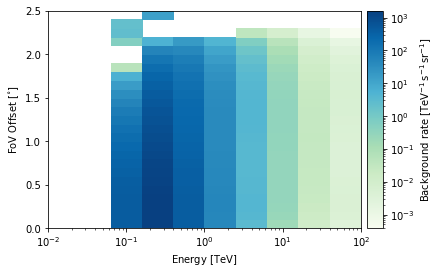

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2020_2021w.fits
V6_2020_2021w (20, 30) (90, 270)


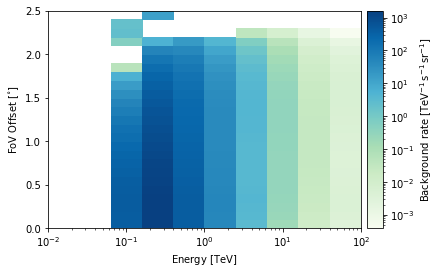

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2020_2021w.fits
V6_2020_2021w (30, 40) (90, 270)


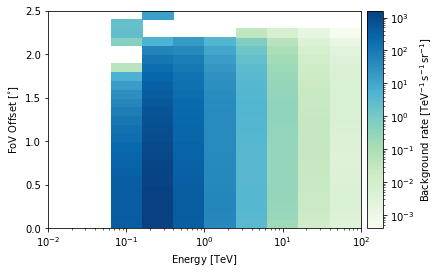

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2020_2021w.fits
V6_2020_2021w (40, 45) (90, 270)


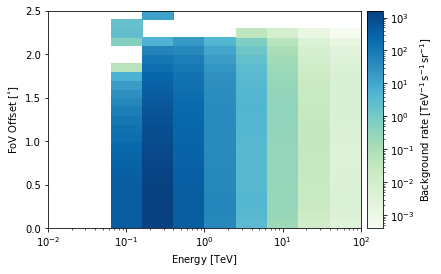

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2020_2021w.fits
V6_2020_2021w (45, 50) (90, 270)


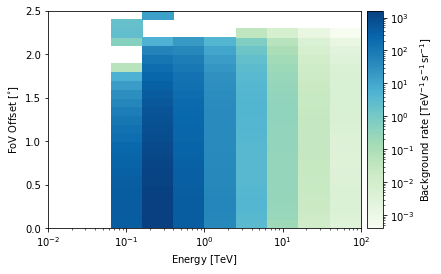

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2020_2021w.fits
V6_2020_2021w (50, 55) (90, 270)


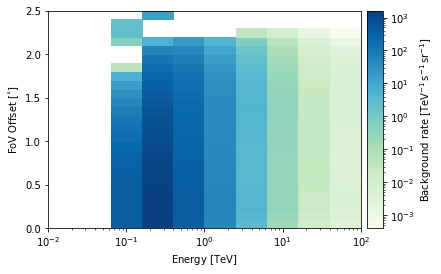

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2020_2021w.fits
V6_2020_2021w (55, 60) (90, 270)


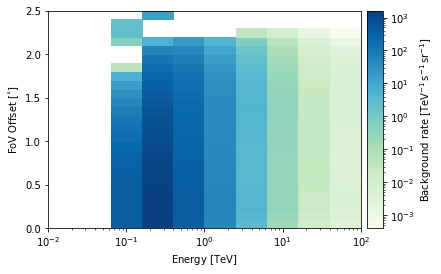

 82%|████████████████████████████████████████████████████████████████████████████▌                | 14/17 [14:07<03:22, 67.50s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2020_2021w.fits
V6_2021_2021s (0, 10) (-90, 90)


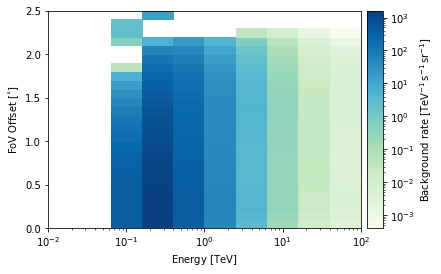

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2021_2021s.fits
V6_2021_2021s (10, 20) (-90, 90)


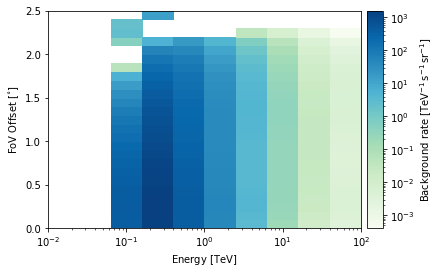

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2021_2021s.fits
V6_2021_2021s (20, 30) (-90, 90)


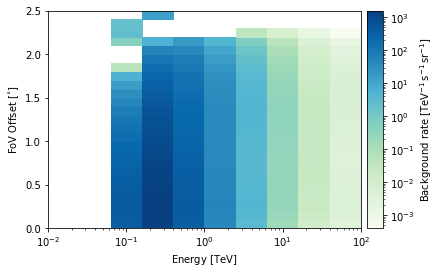

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2021_2021s.fits
V6_2021_2021s (30, 40) (-90, 90)


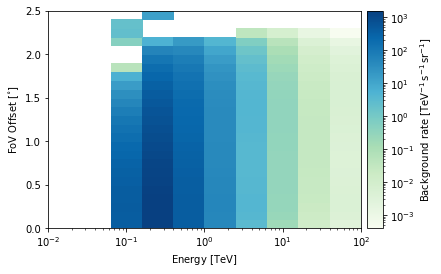

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2021_2021s.fits
V6_2021_2021s (40, 45) (-90, 90)


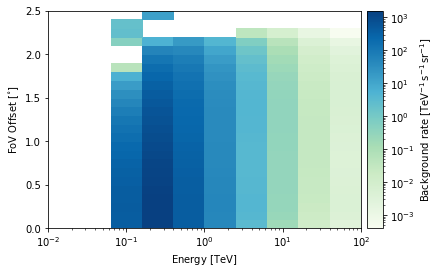

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2021_2021s.fits
V6_2021_2021s (45, 50) (-90, 90)


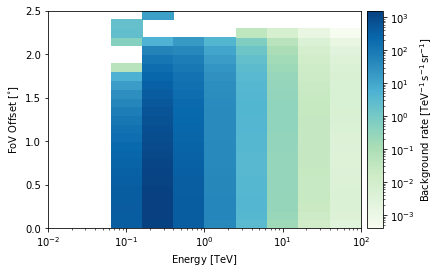

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2021_2021s.fits
V6_2021_2021s (50, 55) (-90, 90)


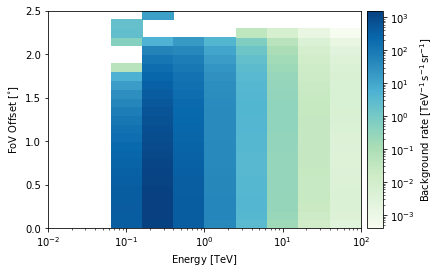

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2021_2021s.fits
V6_2021_2021s (55, 60) (-90, 90)


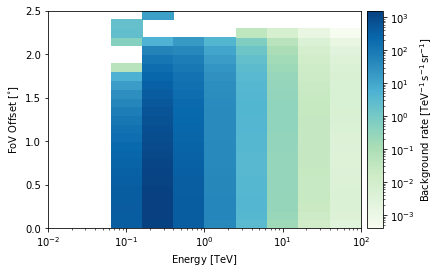

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2021_2021s.fits
V6_2021_2021s (0, 10) (90, 270)


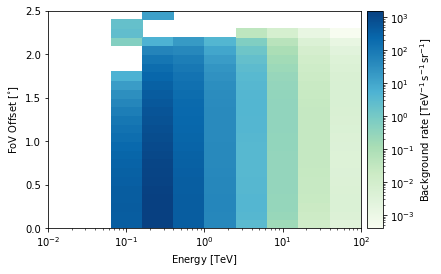

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2021_2021s.fits
V6_2021_2021s (10, 20) (90, 270)


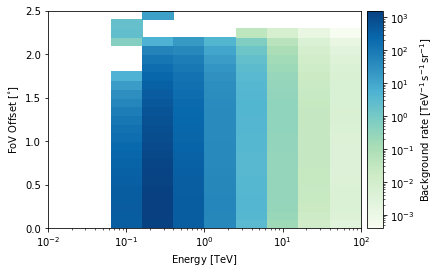

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2021_2021s.fits
V6_2021_2021s (20, 30) (90, 270)


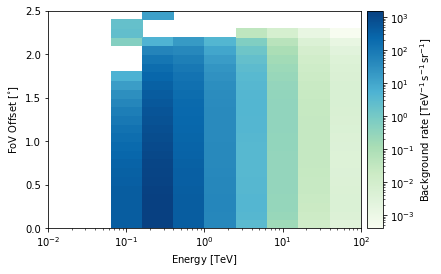

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2021_2021s.fits
V6_2021_2021s (30, 40) (90, 270)


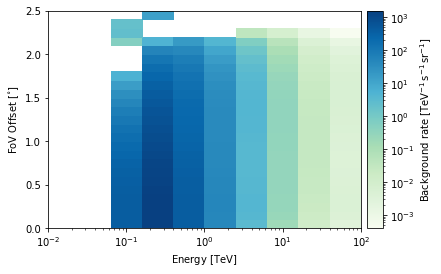

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2021_2021s.fits
V6_2021_2021s (40, 45) (90, 270)


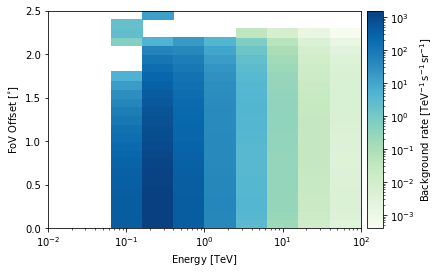

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2021_2021s.fits
V6_2021_2021s (45, 50) (90, 270)


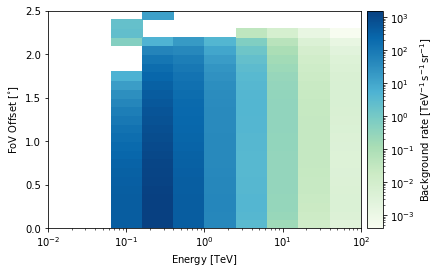

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2021_2021s.fits
V6_2021_2021s (50, 55) (90, 270)


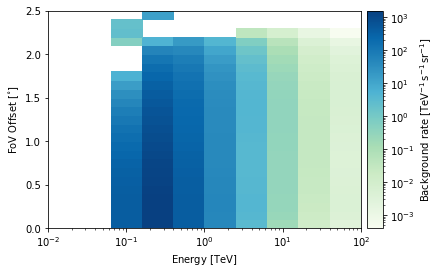

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2021_2021s.fits
V6_2021_2021s (55, 60) (90, 270)


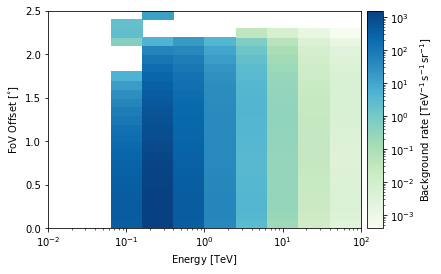

 88%|██████████████████████████████████████████████████████████████████████████████████           | 15/17 [14:55<02:03, 61.91s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2021_2021s.fits
V6_2021_2022w (0, 10) (-90, 90)


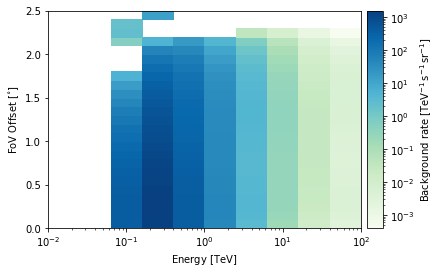

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2021_2022w.fits
V6_2021_2022w (10, 20) (-90, 90)


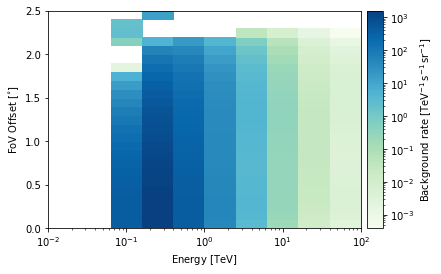

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2021_2022w.fits
V6_2021_2022w (20, 30) (-90, 90)


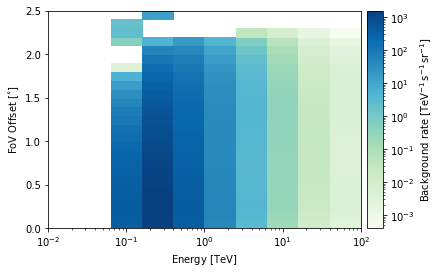

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2021_2022w.fits
V6_2021_2022w (30, 40) (-90, 90)


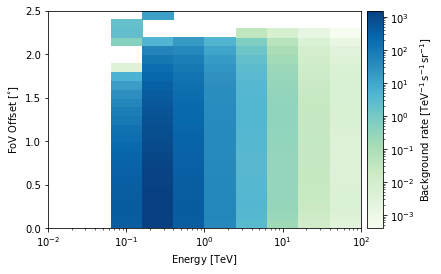

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2021_2022w.fits
V6_2021_2022w (40, 45) (-90, 90)


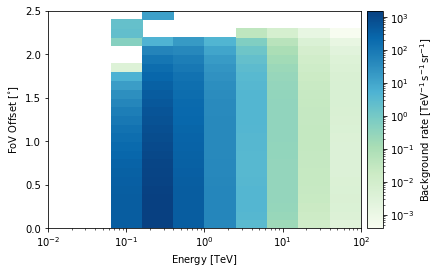

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2021_2022w.fits
V6_2021_2022w (45, 50) (-90, 90)


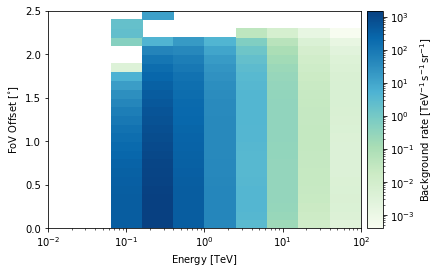

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2021_2022w.fits
V6_2021_2022w (50, 55) (-90, 90)


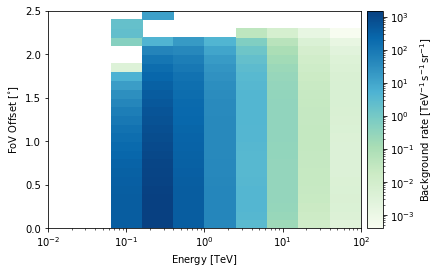

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2021_2022w.fits
V6_2021_2022w (55, 60) (-90, 90)


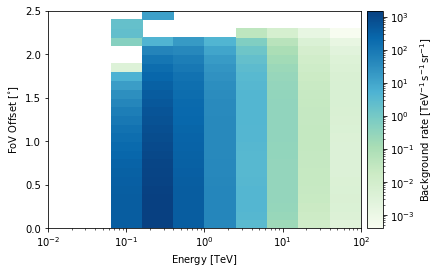

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2021_2022w.fits
V6_2021_2022w (0, 10) (90, 270)


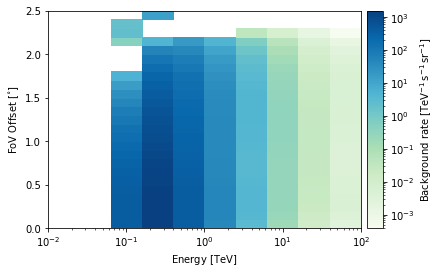

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2021_2022w.fits
V6_2021_2022w (10, 20) (90, 270)


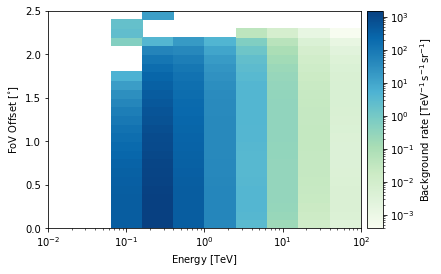

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2021_2022w.fits
V6_2021_2022w (20, 30) (90, 270)


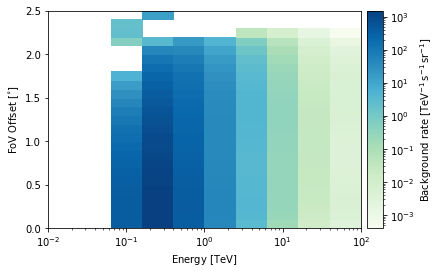

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2021_2022w.fits
V6_2021_2022w (30, 40) (90, 270)


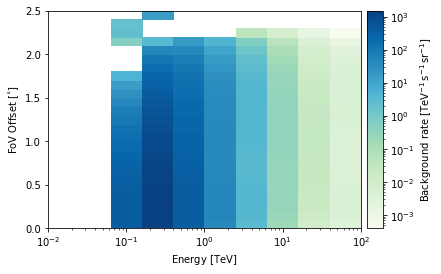

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2021_2022w.fits
V6_2021_2022w (40, 45) (90, 270)


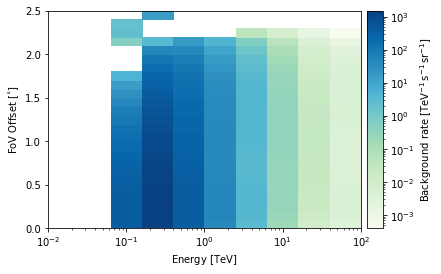

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2021_2022w.fits
V6_2021_2022w (45, 50) (90, 270)


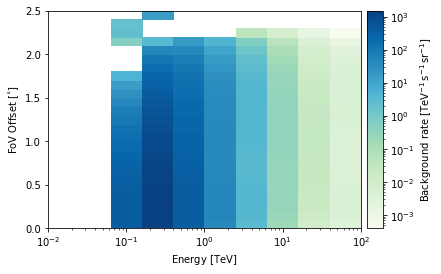

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2021_2022w.fits
V6_2021_2022w (50, 55) (90, 270)


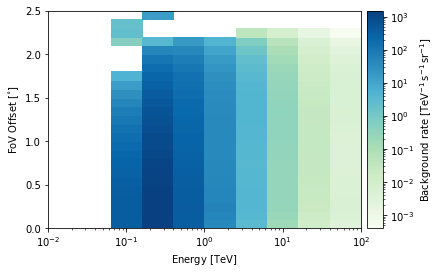

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2021_2022w.fits
V6_2021_2022w (55, 60) (90, 270)


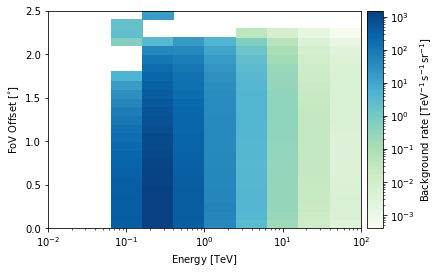

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 16/17 [16:11<01:05, 65.99s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2021_2022w.fits
V6_2022_2022s (0, 10) (-90, 90)


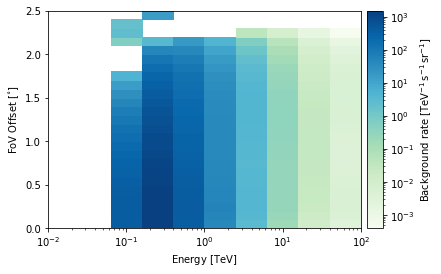

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_0-10_V6_2022_2022s.fits
V6_2022_2022s (10, 20) (-90, 90)


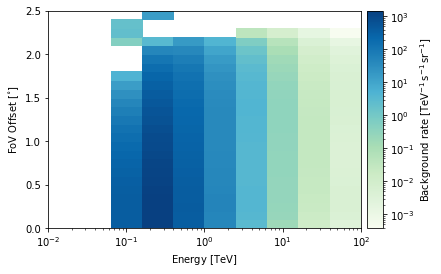

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_10-20_V6_2022_2022s.fits
V6_2022_2022s (20, 30) (-90, 90)


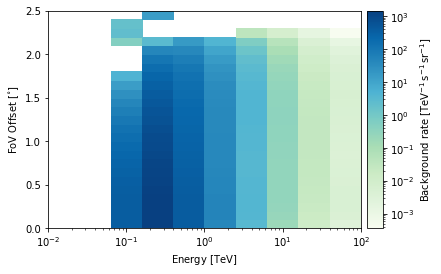

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_20-30_V6_2022_2022s.fits
V6_2022_2022s (30, 40) (-90, 90)


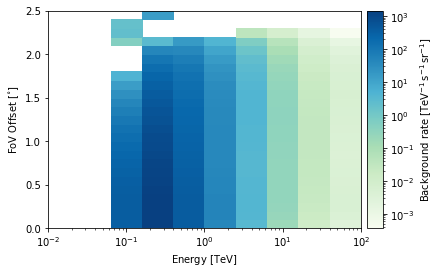

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_30-40_V6_2022_2022s.fits
V6_2022_2022s (40, 45) (-90, 90)


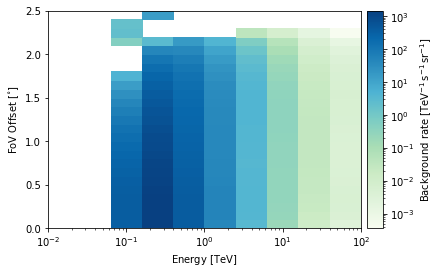

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_40-45_V6_2022_2022s.fits
V6_2022_2022s (45, 50) (-90, 90)


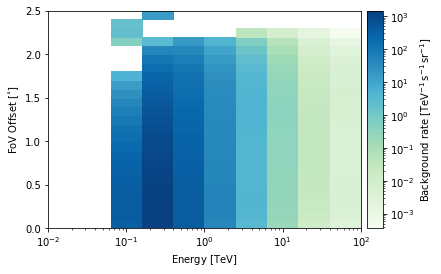

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_45-50_V6_2022_2022s.fits
V6_2022_2022s (50, 55) (-90, 90)


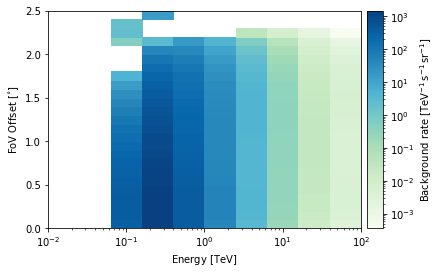

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_50-55_V6_2022_2022s.fits
V6_2022_2022s (55, 60) (-90, 90)


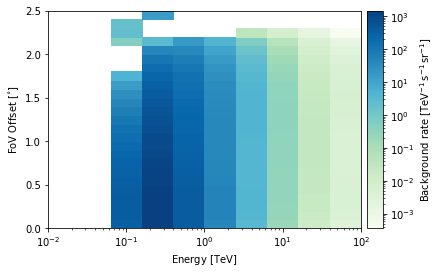

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_-90-90_zenith_55-60_V6_2022_2022s.fits
V6_2022_2022s (0, 10) (90, 270)


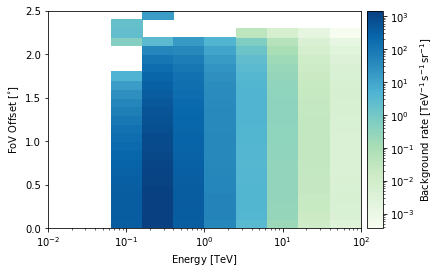

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_0-10_V6_2022_2022s.fits
V6_2022_2022s (10, 20) (90, 270)


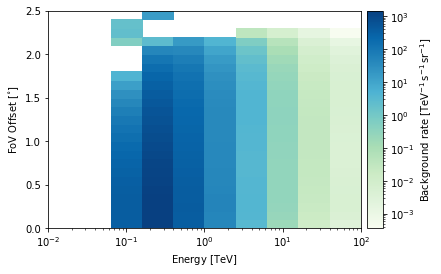

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_10-20_V6_2022_2022s.fits
V6_2022_2022s (20, 30) (90, 270)


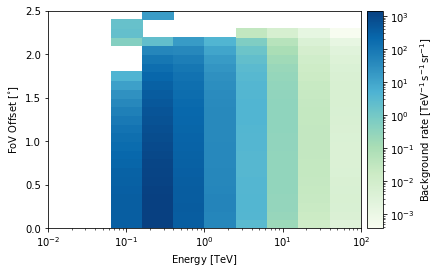

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_20-30_V6_2022_2022s.fits
V6_2022_2022s (30, 40) (90, 270)


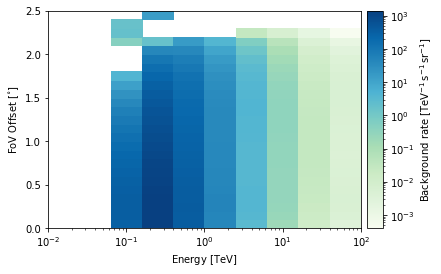

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_30-40_V6_2022_2022s.fits
V6_2022_2022s (40, 45) (90, 270)


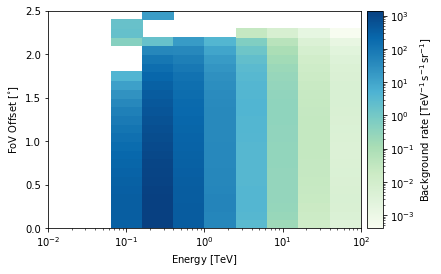

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_40-45_V6_2022_2022s.fits
V6_2022_2022s (45, 50) (90, 270)


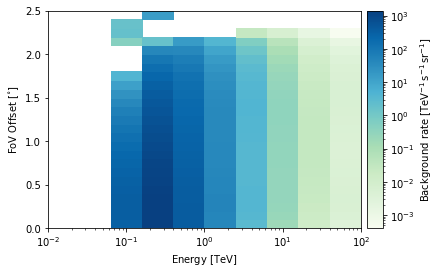

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_45-50_V6_2022_2022s.fits
V6_2022_2022s (50, 55) (90, 270)


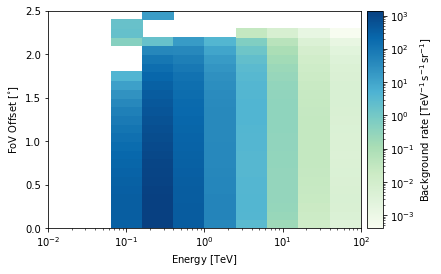

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_50-55_V6_2022_2022s.fits
V6_2022_2022s (55, 60) (90, 270)


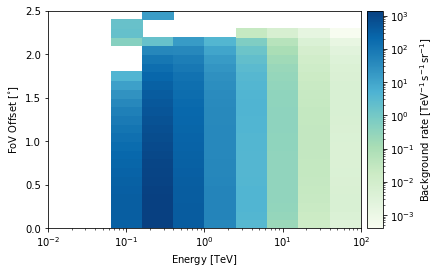

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [19:24<00:00, 68.51s/it]

saved to:/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/bkg2d_e_0.01_100TeV_azimuth_90-270_zenith_55-60_V6_2022_2022s.fits


In [21]:
from datetime import datetime
import os

path = '/raid/romulus/swong/mydl3/lookup_2d_moderate2tel_smooth_491_coarseE/'

import os
if not os.path.exists(path):
    os.makedirs(path)

for epoch in tqdm(epochs):
    for az in azimuths:
        for ze in zeniths:
            print(epoch,ze,az)
            background_meta = {"zen_min": str(ze[0]), "zen_max": str(ze[1]),"e_min": str(emin),
                           "e_max": str(emax), "az_min": str(az[0]), "az_max": str(az[1]), "date": datetime.today().strftime('%Y-%m-%d')}
            filename = "bkg2d_e_" + str(emin) + "_" + str(emax) + "TeV_azimuth_" + str(az[0]) + "-" + str(
                az[1]) + "_zenith_" + str(ze[0]) + "-" + str(ze[1]) + "_" +str(epoch)+ ".fits"
            if filename in os.listdir(path):
                continue
            tstart = epochs[epoch]['tstart']
            tstop = epochs[epoch]['tstop']
            date = runlist['DATE-OBS'].astype('str')
            dates = Time(np.array(date.values.astype('str')),format='isot',scale='utc')
            #mask = (runlist['ZEN_PNT'] >= ze[0]) & (runlist['ZEN_PNT'] < ze[1]) & (dates > tstart) & (dates < tstop)
            mask = (runlist['ZEN_PNT'] >= ze[0]) & (runlist['ZEN_PNT'] < ze[1]) & (runlist['AZ_PNT'] >= az[0])& (runlist['AZ_PNT'] < az[1])&(dates > tstart) & (dates < tstop)
            observations = datastore.get_observations(obs_id=runlist[mask]['OBS_ID'],required_irf="all-optional")
            #np.savetxt(f'{str(epoch)}_runs.txt',np.c_[runlist['OBS_ID'][mask]])
            estimator.run(observations)
            bkg_rate = estimator.background_rate#() #for some reason this needs to not be a function for unsmoothed??
            bkg_rate.plot()
            plt.show()
            hdu_acceptance = bkg_rate.to_table_hdu()
            hdu_acceptance.writeto(path + filename, overwrite=True)
            hdu_acceptance_err = estimator.background_rate_error.to_table_hdu()
            hdu_acceptance_err.writeto(path+"err_"+filename,overwrite=True)
            print('saved to:' + str(path + filename))